In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
N_up = 1
nb_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

                                                            
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Some notes on plotting

* I use green continous lines for learnt depth 
* I use orange -- for loglike when considering every layer in a stochastic resnet
* I use blue -. for loglike when considering up to dopt in a stochastic resnet
* I use red -- for loglike when using deterministic depth models
* Try to stick to the same axis label naming convention across plots

Sample plotting code is at the bottom of the notebook

# setup enviroment

In [40]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np


import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer


import collections
import h5py, sys
import gzip
import os
import math

import time
import torch.utils.data
from torchvision import transforms, datasets
import scipy.ndimage as ndim

try:
    import cPickle as pickle
except:
    import pickle

In [41]:
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

from src.utils import Datafeed
from src.datasets import make_spirals
from net_wrappers import MF_BNN_cat
from src.probability import variational_categorical, fixed_probs
from train_BNN import train_VI_classification
from stochastic_resnet_models import arq_uncert_fc_resnet

from src.plots import evaluate_train_test, errorfill, evaluate_train_test_at_d

%matplotlib inline

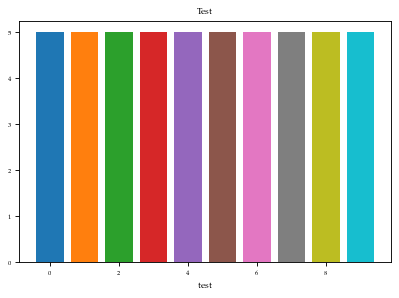

In [42]:

text_width = 5.50107 # in  --> Confirmed with template explanation
# column_width = 3.25063 # in --> Confirmed with template explanation


import matplotlib
# matplotlib.use('pgf')
import matplotlib.pyplot as plt
import seaborn as sns

fs_m1 = 6
fs = 8
fs_p1 = 8

matplotlib.rc('font', serif='Times')
    
matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font',**{'family':'serif','serif':['Palatino']})
matplotlib.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]  
matplotlib.rc('text', usetex=True)


matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
# matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'



base_c10 = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

base_c11k = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000']



i = range(len(base_c10))
a = [5]*len(base_c10)

# plt.figure(dpi=80)
# plt.bar(i,a, color=base_c10)-Copy1-Copy1
# plt.title('$Test$', fontsize=fs_m1)
# plt.xlabel('Test', fontsize=fs)


plt.figure(dpi=80)
plt.bar(i,a, color=base_c10)
plt.title('Test')
plt.xlabel('test')
plt.show()

In [43]:
from src.plots import errorfill

plot_savedir = '../saves/paper_plots/'
datadir = plot_savedir + 'data/'

# Load up results

In [44]:
save_dir = '../saves/'

In [45]:

def load_spirals_t(t, plotnorm=False):

    X, y = make_spirals(n_samples=2000, shuffle=True, noise=0.15, random_state=1234,\
                                         n_arms=2, start_angle=0, stop_angle=180 * t)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1234)

    if plotnorm:
         x_means, x_stds = X_test.mean(axis=0), X_test.std(axis=0)
    else:
        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)

    X_train = ((X_train - x_means) / x_stds).astype(np.float32)
    X_test = ((X_test - x_means) / x_stds).astype(np.float32)

    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    return X_train, X_test, y_train, y_test

def load_spirals_ndata(t, plotnorm=False):

    X, y = make_spirals(n_samples=500*t, shuffle=True, noise=0.15, random_state=1234,\
                                         n_arms=2, start_angle=0, stop_angle=720)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1234)
    
    if plotnorm:
        x_means, x_stds = X_test.mean(axis=0), X_test.std(axis=0)
    else:
        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = ((X_train - x_means) / x_stds).astype(np.float32)
    X_test = ((X_test - x_means) / x_stds).astype(np.float32)

    y_train = y_train.astype(np.float32)
    y_test = y_test.astype(np.float32)
    return X_train, X_test, y_train, y_test


def get_run_mean_std(struct, last_max=False, last_min=False, last_argmax=False, last_argmin=False):
    
    means = []
    stds = []
    for exp in struct:
        
        if last_max:
            exp = exp.max(axis=1)
        elif last_min:
            exp = exp.min(axis=1)
        elif last_argmax:
            exp = exp.argmax(axis=1)
        elif last_argmin:
            exp = exp.argmin(axis=1)
        
        means.append(np.nanmean(exp, axis=0))
        stds.append(np.nanstd(exp, axis=0))
        
    return np.array(means), np.array(stds)





## Scan over spiral angle

In [46]:
experiment_dir = save_dir + 'fc_BNN_spirals_cat/' + 'spiral_scan/'

### Initialise base model to load into

In [47]:
cuda = torch.cuda.is_available()
input_dim = 2
width = 20
n_layers = 20
output_dim = 2

prior_probs = 0.85 ** (1 + np.arange(n_layers + 1))
prior_probs = prior_probs / prior_probs.sum()

# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)

prob_model = variational_categorical(n_layers, prior_probs, temp=0.1, eps=1e-10, cuda=cuda)

# prob_model = fixed_probs(n_layers, probs=[1/(n_layers+1)], distribution_name='cat', cuda=True)

tags = {'direct_trained': True}

model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=width, n_layers=n_layers, prob_model=prob_model)
N_train = 2000 * 0.1
lr = 1e-1
net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)



Net:
MF BNN categorical output
    Total params: 0.01M


### Iterate over experiment saves and retrieve results

In [48]:

base_angle = 180

rotations = []
per_rotation_q = []
per_rotation_KL = []

per_rotation_train_loglike = []
per_rotation_train_err = []
per_rotation_test_loglike = []
per_rotation_test_err = []

per_rotation_train_loglike_d = []
per_rotation_train_err_d = []
per_rotation_test_loglike_d = []
per_rotation_test_err_d = []


# evaluate_train_test_at_d

#iterate over experiment settings
exp_folders = os.listdir(experiment_dir)
for exp_folder in exp_folders: # loop through all the files and folders
    full_exp_folder = os.path.join(experiment_dir, exp_folder)
    if os.path.isdir(full_exp_folder): # check whether the current object is a folder or not
        
        X_train, X_test, y_train, y_test = load_spirals_t(int(exp_folder))
#         print(int(exp_folder))
        angle = base_angle * int(exp_folder)
        rotations.append(angle)
        
        per_rotation_q.append([])
        per_rotation_KL.append([])
        per_rotation_train_loglike.append([])
        per_rotation_train_err.append([])
        per_rotation_test_loglike.append([])
        per_rotation_test_err.append([])
        
        per_rotation_train_loglike_d.append([])
        per_rotation_train_err_d.append([])
        per_rotation_test_loglike_d.append([])
        per_rotation_test_err_d.append([])
        
        
        N_run_folders = os.listdir(full_exp_folder)
        for N_run_folder in N_run_folders: # loop through all the files and folders
            model_folder = os.path.join(full_exp_folder, N_run_folder, 'models')
            if os.path.isdir(model_folder): # check whether the current object is a folder or not
                
                try:
                    net.load(model_folder + '/theta_best.dat')
                except E:
                    print('could not load: ' + model_folder)
                    continue
                
                per_rotation_q[-1].append(net.model.prob_model.get_q_probs().data.cpu().numpy())
                per_rotation_KL[-1].append(net.model.get_KL().item())
                
                max_d = net.model.prob_model.get_q_probs().data.cpu().numpy().argmax()
                print(max_d)
                
                loglike_train, loglike_test, err_train, err_test = \
                    evaluate_train_test(net, X_train, y_train, X_test, y_test)
                    
                per_rotation_train_loglike[-1].append(loglike_train)
                per_rotation_train_err[-1].append(err_train)
                per_rotation_test_loglike[-1].append(loglike_test)
                per_rotation_test_err[-1].append(err_test)
                
                loglike_train_d, loglike_test_d, err_train_d, err_test_d = \
                    evaluate_train_test_at_d(net, X_train, y_train, X_test, y_test, d=max_d)
                
                per_rotation_train_loglike_d[-1].append(loglike_train_d)
                per_rotation_train_err_d[-1].append(err_train_d)
                per_rotation_test_loglike_d[-1].append(loglike_test_d)
                per_rotation_test_err_d[-1].append(err_test_d)
                
        
        per_rotation_q[-1] = np.stack(per_rotation_q[-1], axis=0)
        per_rotation_KL[-1] = np.array(per_rotation_KL[-1])
        per_rotation_train_loglike[-1] = np.array(per_rotation_train_loglike[-1])
        per_rotation_train_err[-1] = np.array(per_rotation_train_err[-1])
        per_rotation_test_loglike[-1] = np.array(per_rotation_test_loglike[-1])
        per_rotation_test_err[-1] = np.array(per_rotation_test_err[-1])
        
        per_rotation_train_loglike_d[-1] = np.array(per_rotation_train_loglike_d[-1])
        per_rotation_train_err_d[-1] = np.array(per_rotation_train_err_d[-1])
        per_rotation_test_loglike_d[-1] = np.array(per_rotation_test_loglike_d[-1])
        per_rotation_test_err_d[-1] = np.array(per_rotation_test_err_d[-1])
        
        
# per_rotation_q = np.stack(per_rotation_q, axis=0)
# per_rotation_KL = np.stack(per_rotation_KL, axis=0)
# per_rotation_train_loglike = np.stack(per_rotation_train_loglike, axis=0)
# per_rotation_train_err = np.stack(per_rotation_train_err, axis=0)
# per_rotation_test_loglike = np.stack(per_rotation_test_loglike, axis=0)
# per_rotation_test_err = np.stack(per_rotation_test_err, axis=0)
        
        
                
sort_idxs = np.argsort(rotations)

rotations = np.array(rotations)[sort_idxs]

per_rotation_q = [per_rotation_q[i] for i in sort_idxs]
per_rotation_KL = [per_rotation_KL[i] for i in sort_idxs]
per_rotation_train_loglike = [per_rotation_train_loglike[i] for i in sort_idxs]
per_rotation_train_err = [per_rotation_train_err[i] for i in sort_idxs]
per_rotation_test_loglike = [per_rotation_test_loglike[i] for i in sort_idxs]
per_rotation_test_err = [per_rotation_test_err[i] for i in sort_idxs]


per_rotation_train_loglike_d = [per_rotation_train_loglike_d[i] for i in sort_idxs]
per_rotation_train_err_d = [per_rotation_train_err_d[i] for i in sort_idxs]
per_rotation_test_loglike_d = [per_rotation_test_loglike_d[i] for i in sort_idxs]
per_rotation_test_err_d = [per_rotation_test_err_d[i] for i in sort_idxs]
                
        
        

Reading ../saves/fc_BNN_spirals_cat/spiral_scan/6/version_6/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
12
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/6/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
10
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/6/version_3/models/theta_best.dat

  restoring epoch: 2423, lr: 0.100000
13
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/6/version_0/models/theta_best.dat

  restoring epoch: 922, lr: 0.100000
14
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/6/version_2/models/theta_best.dat

  restoring epoch: 2800, lr: 0.100000
17
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/6/version_1/models/theta_best.dat

  restoring epoch: 1623, lr: 0.100000
16
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/6/version_5/models/theta_best.dat

  restoring epoch: 7999, lr: 0.100000
8
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/4/version_6/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
8
Reading ../

  restoring epoch: 8000, lr: 0.100000
2
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/1/version_5/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
2
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/5/version_6/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
9
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/5/version_4/models/theta_best.dat

  restoring epoch: 1649, lr: 0.100000
14
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/5/version_3/models/theta_best.dat

  restoring epoch: 3118, lr: 0.100000
12
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/5/version_0/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
13
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/5/version_2/models/theta_best.dat

  restoring epoch: 1404, lr: 0.100000
15
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/5/version_1/models/theta_best.dat

  restoring epoch: 1543, lr: 0.100000
11
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/5/version_5/models/theta_best.dat

  restoring

#### plots

## Scan over Ndata

In [49]:
experiment_dir = save_dir + 'fc_BNN_spirals_cat/' + 'Ndata_scan/'

In [50]:
cuda = torch.cuda.is_available()
input_dim = 2
width = 20
n_layers = 20
output_dim = 2

prior_probs = 0.85 ** (1 + np.arange(n_layers + 1))
prior_probs = prior_probs / prior_probs.sum()

# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)

prob_model = variational_categorical(n_layers, prior_probs, temp=0.1, eps=1e-10, cuda=cuda)

# prob_model = fixed_probs(n_layers, probs=[1/(n_layers+1)], distribution_name='cat', cuda=True)

tags = {'direct_trained': True}

model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=width, n_layers=n_layers, prob_model=prob_model)
N_train = 2000 * 0.1
lr = 1e-1
net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)




Net:
MF BNN categorical output
    Total params: 0.01M


In [51]:
X_train, X_test, y_train, y_test = load_spirals_t(4)


Ndata = []
per_Ndata_q = []
per_Ndata_KL = []

per_Ndata_train_loglike = []
per_Ndata_train_err = []
per_Ndata_test_loglike = []
per_Ndata_test_err = []

per_Ndata_train_loglike_d = []
per_Ndata_train_err_d = []
per_Ndata_test_loglike_d = []
per_Ndata_test_err_d = []



#iterate over experiment settings
exp_folders = os.listdir(experiment_dir)
for exp_folder in exp_folders: # loop through all the files and folders
    full_exp_folder = os.path.join(experiment_dir, exp_folder)
    if os.path.isdir(full_exp_folder): # check whether the current object is a folder or not
        
        if exp_folder[0] == '.':
            continue
        Ndata.append(int(exp_folder)*10)
        
        per_Ndata_q.append([])
        per_Ndata_KL.append([])
        per_Ndata_train_loglike.append([])
        per_Ndata_train_err.append([])
        per_Ndata_test_loglike.append([])
        per_Ndata_test_err.append([])
        
        per_Ndata_train_loglike_d.append([])
        per_Ndata_train_err_d.append([])
        per_Ndata_test_loglike_d.append([])
        per_Ndata_test_err_d.append([])
        
        
        N_run_folders = os.listdir(full_exp_folder)
        for N_run_folder in N_run_folders: # loop through all the files and folders
            model_folder = os.path.join(full_exp_folder, N_run_folder, 'models')
            if os.path.isdir(model_folder): # check whether the current object is a folder or not
                
                try:
                    net.load(model_folder + '/theta_best.dat')
                except:
                    print('could not load: ' + model_folder)
                    continue
                
                per_Ndata_q[-1].append(net.model.prob_model.get_q_probs().data.cpu().numpy())
                per_Ndata_KL[-1].append(net.model.get_KL().item())
                
                loglike_train, loglike_test, err_train, err_test = \
                    evaluate_train_test(net, X_train, y_train, X_test, y_test)
                    
                per_Ndata_train_loglike[-1].append(loglike_train)
                per_Ndata_train_err[-1].append(err_train)
                per_Ndata_test_loglike[-1].append(loglike_test)
                per_Ndata_test_err[-1].append(err_test)
                
                max_d = net.model.prob_model.get_q_probs().data.cpu().numpy().argmax()
                print(max_d)
                
                loglike_train_d, loglike_test_d, err_train_d, err_test_d = \
                    evaluate_train_test_at_d(net, X_train, y_train, X_test, y_test, d=max_d)
                
                per_Ndata_train_loglike_d[-1].append(loglike_train_d)
                per_Ndata_train_err_d[-1].append(err_train_d)
                per_Ndata_test_loglike_d[-1].append(loglike_test_d)
                per_Ndata_test_err_d[-1].append(err_test_d)
                
        
        per_Ndata_q[-1] = np.stack(per_Ndata_q[-1], axis=0)
        per_Ndata_KL[-1] = np.array(per_Ndata_KL[-1])
        per_Ndata_train_loglike[-1] = np.array(per_Ndata_train_loglike[-1])
        per_Ndata_train_err[-1] = np.array(per_Ndata_train_err[-1])
        per_Ndata_test_loglike[-1] = np.array(per_Ndata_test_loglike[-1])
        per_Ndata_test_err[-1] = np.array(per_Ndata_test_err[-1])
        
        per_Ndata_train_loglike_d[-1] = np.array(per_Ndata_train_loglike_d[-1])
        per_Ndata_train_err_d[-1] = np.array(per_Ndata_train_err_d[-1])
        per_Ndata_test_loglike_d[-1] = np.array(per_Ndata_test_loglike_d[-1])
        per_Ndata_test_err_d[-1] = np.array(per_Ndata_test_err_d[-1])
        
        
# per_Ndata_q = np.stack(per_Ndata_q, axis=0)
# per_Ndata_KL = np.stack(per_Ndata_KL, axis=0)
# per_Ndata_train_loglike = np.stack(per_Ndata_train_loglike, axis=0)
# per_Ndata_train_err = np.stack(per_Ndata_train_err, axis=0)
# per_Ndata_test_loglike = np.stack(per_Ndata_test_loglike, axis=0)
# per_Ndata_test_err = np.stack(per_Ndata_test_err, axis=0)
        
        
sort_idxs = np.argsort(Ndata)

Ndata = np.array(Ndata)[sort_idxs]

per_Ndata_q = [per_Ndata_q[i] for i in sort_idxs]
per_Ndata_KL = [per_Ndata_KL[i] for i in sort_idxs]
per_Ndata_train_loglike = [per_Ndata_train_loglike[i] for i in sort_idxs]
per_Ndata_train_err = [per_Ndata_train_err[i] for i in sort_idxs]
per_Ndata_test_loglike = [per_Ndata_test_loglike[i] for i in sort_idxs]
per_Ndata_test_err = [per_Ndata_test_err[i] for i in sort_idxs]

per_Ndata_train_loglike_d = [per_Ndata_train_loglike_d[i] for i in sort_idxs]
per_Ndata_train_err_d = [per_Ndata_train_err_d[i] for i in sort_idxs]
per_Ndata_test_loglike_d = [per_Ndata_test_loglike_d[i] for i in sort_idxs]
per_Ndata_test_err_d = [per_Ndata_test_err_d[i] for i in sort_idxs]

                
                
        
        

Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/750/version_0/models/theta_best.dat

  restoring epoch: 5818, lr: 0.100000
12
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/750/version_2/models/theta_best.dat

  restoring epoch: 989, lr: 0.100000
12
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/750/version_1/models/theta_best.dat

  restoring epoch: 2328, lr: 0.100000
13
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/300/version_6/models/theta_best.dat

  restoring epoch: 7998, lr: 0.100000
9
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/300/version_8/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
8
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/300/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
10
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/300/version_7/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
9
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/300/version_3/models/theta_best.dat

  restoring epoch: 832, lr: 0.100000
13
Readi

  restoring epoch: 4184, lr: 0.100000
9
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/700/version_9/models/theta_best.dat

  restoring epoch: 6874, lr: 0.100000
10
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/700/version_1/models/theta_best.dat

  restoring epoch: 7657, lr: 0.100000
12
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/700/version_10/models/theta_best.dat

  restoring epoch: 7976, lr: 0.100000
9
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/700/version_5/models/theta_best.dat

  restoring epoch: 5941, lr: 0.100000
9
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/800/version_6/models/theta_best.dat

  restoring epoch: 6680, lr: 0.100000
12
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/800/version_4/models/theta_best.dat

  restoring epoch: 958, lr: 0.100000
14
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/800/version_3/models/theta_best.dat

  restoring epoch: 4024, lr: 0.100000
11
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/800/version_0/models/theta_best.dat

  r

  restoring epoch: 8000, lr: 0.100000
4
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/100/version_3/models/theta_best.dat

  restoring epoch: 2961, lr: 0.100000
8
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/100/version_0/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
6
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/100/version_2/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
5
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/100/version_9/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
6
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/100/version_1/models/theta_best.dat

  restoring epoch: 1094, lr: 0.100000
9
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/100/version_5/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
7
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/200/version_6/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
6
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan/200/version_8/models/theta_best.dat

  restor

## Scan over Width

In [52]:
experiment_dir = save_dir + 'fc_BNN_spirals_cat/' + 'width_scan/'

In [53]:
cuda = torch.cuda.is_available()
input_dim = 2

n_layers = 20
output_dim = 2

prior_probs = 0.85 ** (1 + np.arange(n_layers + 1))
prior_probs = prior_probs / prior_probs.sum()

# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)

prob_model = variational_categorical(n_layers, prior_probs, temp=0.1, eps=1e-10, cuda=cuda)

# prob_model = fixed_probs(n_layers, probs=[1/(n_layers+1)], distribution_name='cat', cuda=True)

tags = {'direct_trained': True}


############

N_train = 2000 * 0.1
lr = 1e-1


In [54]:
X_train, X_test, y_train, y_test = load_spirals_t(4)


widths = []
per_width_q = []
per_width_KL = []

per_width_train_loglike = []
per_width_train_err = []
per_width_test_loglike = []
per_width_test_err = []

per_width_train_loglike_d = []
per_width_train_err_d = []
per_width_test_loglike_d = []
per_width_test_err_d = []



#iterate over experiment settings
exp_folders = os.listdir(experiment_dir)
for exp_folder in exp_folders: # loop through all the files and folders
    full_exp_folder = os.path.join(experiment_dir, exp_folder)
    if os.path.isdir(full_exp_folder): # check whether the current object is a folder or not
        
        if exp_folder[0] == '.':
            continue
        
        print(int(exp_folder))
        model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=int(exp_folder), n_layers=n_layers, prob_model=prob_model)
        net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)
            
        widths.append(int(exp_folder))
        
        per_width_q.append([])
        per_width_KL.append([])
        per_width_train_loglike.append([])
        per_width_train_err.append([])
        per_width_test_loglike.append([])
        per_width_test_err.append([])
        
        per_width_train_loglike_d.append([])
        per_width_train_err_d.append([])
        per_width_test_loglike_d.append([])
        per_width_test_err_d.append([])
        
        
        N_run_folders = os.listdir(full_exp_folder)
        for N_run_folder in N_run_folders: # loop through all the files and folders
            model_folder = os.path.join(full_exp_folder, N_run_folder, 'models')
            if os.path.isdir(model_folder): # check whether the current object is a folder or not
                
                try:
                    net.load(model_folder + '/theta_best.dat')
                except E:
                    print('could not load: ' + model_folder)
                    continue
                
                per_width_q[-1].append(net.model.prob_model.get_q_probs().data.cpu().numpy())
                per_width_KL[-1].append(net.model.get_KL().item())
                
                loglike_train, loglike_test, err_train, err_test = \
                    evaluate_train_test(net, X_train, y_train, X_test, y_test)
                    
                per_width_train_loglike[-1].append(loglike_train)
                per_width_train_err[-1].append(err_train)
                per_width_test_loglike[-1].append(loglike_test)
                per_width_test_err[-1].append(err_test)
                
                max_d = net.model.prob_model.get_q_probs().data.cpu().numpy().argmax()
                print(max_d)
                
                loglike_train_d, loglike_test_d, err_train_d, err_test_d = \
                    evaluate_train_test_at_d(net, X_train, y_train, X_test, y_test, d=max_d)
                
                per_width_train_loglike_d[-1].append(loglike_train_d)
                per_width_train_err_d[-1].append(err_train_d)
                per_width_test_loglike_d[-1].append(loglike_test_d)
                per_width_test_err_d[-1].append(err_test_d)
                
        
        per_width_q[-1] = np.stack(per_width_q[-1], axis=0)
        per_width_KL[-1] = np.array(per_width_KL[-1])
        per_width_train_loglike[-1] = np.array(per_width_train_loglike[-1])
        per_width_train_err[-1] = np.array(per_width_train_err[-1])
        per_width_test_loglike[-1] = np.array(per_width_test_loglike[-1])
        per_width_test_err[-1] = np.array(per_width_test_err[-1])
        
        per_width_train_loglike_d[-1] = np.array(per_width_train_loglike_d[-1])
        per_width_train_err_d[-1] = np.array(per_width_train_err_d[-1])
        per_width_test_loglike_d[-1] = np.array(per_width_test_loglike_d[-1])
        per_width_test_err_d[-1] = np.array(per_width_test_err_d[-1])
        
        
# per_width_q = np.stack(per_width_q, axis=0)
# per_width_KL = np.stack(per_width_KL, axis=0)
# per_width_train_loglike = np.stack(per_width_train_loglike, axis=0)
# per_width_train_err = np.stack(per_width_train_err, axis=0)
# per_width_test_loglike = np.stack(per_width_test_loglike, axis=0)
# per_width_test_err = np.stack(per_width_test_err, axis=0)
        
        
                
sort_idxs = np.argsort(widths)

widths = np.array(widths)[sort_idxs]

per_width_q = [per_width_q[i] for i in sort_idxs]
per_width_KL = [per_width_KL[i] for i in sort_idxs]
per_width_train_loglike = [per_width_train_loglike[i] for i in sort_idxs]
per_width_train_err = [per_width_train_err[i] for i in sort_idxs]
per_width_test_loglike = [per_width_test_loglike[i] for i in sort_idxs]
per_width_test_err = [per_width_test_err[i] for i in sort_idxs]

per_width_train_loglike_d = [per_width_train_loglike_d[i] for i in sort_idxs]
per_width_train_err_d = [per_width_train_err_d[i] for i in sort_idxs]
per_width_test_loglike_d = [per_width_test_loglike_d[i] for i in sort_idxs]
per_width_test_err_d = [per_width_test_err_d[i] for i in sort_idxs]


                
        
        

10

Net:
MF BNN categorical output
    Total params: 0.00M
Reading ../saves/fc_BNN_spirals_cat/width_scan/10/version_6/models/theta_best.dat

  restoring epoch: 625, lr: 0.100000
15
Reading ../saves/fc_BNN_spirals_cat/width_scan/10/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
9
Reading ../saves/fc_BNN_spirals_cat/width_scan/10/version_3/models/theta_best.dat

  restoring epoch: 2356, lr: 0.100000
13
Reading ../saves/fc_BNN_spirals_cat/width_scan/10/version_0/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
11
Reading ../saves/fc_BNN_spirals_cat/width_scan/10/version_2/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
7
Reading ../saves/fc_BNN_spirals_cat/width_scan/10/version_1/models/theta_best.dat

  restoring epoch: 2118, lr: 0.100000
20
Reading ../saves/fc_BNN_spirals_cat/width_scan/10/version_5/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
8
60

Net:
MF BNN categorical output
    Total params: 0.08M
Reading ../saves/f

  restoring epoch: 1141, lr: 0.100000
5
200

Net:
MF BNN categorical output
    Total params: 0.81M
Reading ../saves/fc_BNN_spirals_cat/width_scan/200/version_6/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
4
Reading ../saves/fc_BNN_spirals_cat/width_scan/200/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
4
Reading ../saves/fc_BNN_spirals_cat/width_scan/200/version_3/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
3
Reading ../saves/fc_BNN_spirals_cat/width_scan/200/version_0/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
3
Reading ../saves/fc_BNN_spirals_cat/width_scan/200/version_2/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
4
Reading ../saves/fc_BNN_spirals_cat/width_scan/200/version_1/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
3
Reading ../saves/fc_BNN_spirals_cat/width_scan/200/version_5/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
3
40

Net:
MF BNN categorical outp

## Scan over Depth

In [55]:
experiment_dir = save_dir + 'fc_BNN_spirals_cat/' + 'depth_scan/'

In [56]:
cuda = torch.cuda.is_available()
input_dim = 2
width = 20

output_dim = 2

# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)



# prob_model = fixed_probs(n_layers, probs=[1/(n_layers+1)], distribution_name='cat', cuda=True)

tags = {'direct_trained': True}


N_train = 2000 * 0.1
lr = 1e-1






In [57]:
X_train, X_test, y_train, y_test = load_spirals_t(4)


max_depths = []
per_max_depth_q = []
per_max_depth_KL = []

per_max_depth_train_loglike = []
per_max_depth_train_err = []
per_max_depth_test_loglike = []
per_max_depth_test_err = []

per_max_depth_train_loglike_d = []
per_max_depth_train_err_d = []
per_max_depth_test_loglike_d = []
per_max_depth_test_err_d = []



#iterate over experiment settings
exp_folders = os.listdir(experiment_dir)
for exp_folder in exp_folders: # loop through all the files and folders
    full_exp_folder = os.path.join(experiment_dir, exp_folder)
    if os.path.isdir(full_exp_folder): # check whether the current object is a folder or not
        
        if exp_folder[0] == '.':
            continue
        
        print(int(exp_folder))
        
        prior_probs = 0.85 ** (1 + np.arange(int(exp_folder) + 1))
        prior_probs = prior_probs / prior_probs.sum()
        prob_model = variational_categorical(int(exp_folder), prior_probs, temp=0.1, eps=1e-10, cuda=cuda)
        model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                                     width=width, n_layers=int(exp_folder), prob_model=prob_model)
        net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)    
        max_depths.append(int(exp_folder))
        
        per_max_depth_q.append([])
        per_max_depth_KL.append([])
        per_max_depth_train_loglike.append([])
        per_max_depth_train_err.append([])
        per_max_depth_test_loglike.append([])
        per_max_depth_test_err.append([])
        
        per_max_depth_train_loglike_d.append([])
        per_max_depth_train_err_d.append([])
        per_max_depth_test_loglike_d.append([])
        per_max_depth_test_err_d.append([])
        
        
        N_run_folders = os.listdir(full_exp_folder)
        for N_run_folder in N_run_folders: # loop through all the files and folders
            model_folder = os.path.join(full_exp_folder, N_run_folder, 'models')
            if os.path.isdir(model_folder): # check whether the current object is a folder or not
                
                try:
                    net.load(model_folder + '/theta_best.dat')
                except:
                    print('could not load: ' + model_folder)
                    continue
                
                per_max_depth_q[-1].append(net.model.prob_model.get_q_probs().data.cpu().numpy())
                per_max_depth_KL[-1].append(net.model.get_KL().item())
                
                loglike_train, loglike_test, err_train, err_test = \
                    evaluate_train_test(net, X_train, y_train, X_test, y_test)
                    
                per_max_depth_train_loglike[-1].append(loglike_train)
                per_max_depth_train_err[-1].append(err_train)
                per_max_depth_test_loglike[-1].append(loglike_test)
                per_max_depth_test_err[-1].append(err_test)
                
                max_d = net.model.prob_model.get_q_probs().data.cpu().numpy().argmax()
                print(per_max_depth_q[-1][-1].shape, max_d)
                print(net.model.prob_model.get_q_probs().shape)
                
                loglike_train_d, loglike_test_d, err_train_d, err_test_d = \
                    evaluate_train_test_at_d(net, X_train, y_train, X_test, y_test, d=max_d)
                
                per_max_depth_train_loglike_d[-1].append(loglike_train_d)
                per_max_depth_train_err_d[-1].append(err_train_d)
                per_max_depth_test_loglike_d[-1].append(loglike_test_d)
                per_max_depth_test_err_d[-1].append(err_test_d)
                
                
                
        
        per_max_depth_q[-1] = np.stack(per_max_depth_q[-1], axis=0)
        per_max_depth_KL[-1] = np.array(per_max_depth_KL[-1])
        per_max_depth_train_loglike[-1] = np.array(per_max_depth_train_loglike[-1])
        per_max_depth_train_err[-1] = np.array(per_max_depth_train_err[-1])
        per_max_depth_test_loglike[-1] = np.array(per_max_depth_test_loglike[-1])
        per_max_depth_test_err[-1] = np.array(per_max_depth_test_err[-1])
        
        per_max_depth_train_loglike_d[-1] = np.array(per_max_depth_train_loglike_d[-1])
        per_max_depth_train_err_d[-1] = np.array(per_max_depth_train_err_d[-1])
        per_max_depth_test_loglike_d[-1] = np.array(per_max_depth_test_loglike_d[-1])
        per_max_depth_test_err_d[-1] = np.array(per_max_depth_test_err_d[-1])
        
        
# per_max_depth_q = np.stack(per_max_depth_q, axis=0)
# per_max_depth_KL = np.stack(per_max_depth_KL, axis=0)
# per_max_depth_train_loglike = np.stack(per_max_depth_train_loglike, axis=0)
# per_max_depth_train_err = np.stack(per_max_depth_train_err, axis=0)
# per_max_depth_test_loglike = np.stack(per_max_depth_test_loglike, axis=0)
# per_max_depth_test_err = np.stack(per_max_depth_test_err, axis=0)
        
        
                
sort_idxs = np.argsort(max_depths)

max_depths = np.array(max_depths)[sort_idxs]

per_max_depth_q = [per_max_depth_q[i] for i in sort_idxs]
per_max_depth_KL = [per_max_depth_KL[i] for i in sort_idxs]
per_max_depth_train_loglike = [per_max_depth_train_loglike[i] for i in sort_idxs]
per_max_depth_train_err = [per_max_depth_train_err[i] for i in sort_idxs]
per_max_depth_test_loglike = [per_max_depth_test_loglike[i] for i in sort_idxs]
per_max_depth_test_err = [per_max_depth_test_err[i] for i in sort_idxs]


per_max_depth_train_loglike_d = [per_max_depth_train_loglike_d[i] for i in sort_idxs]
per_max_depth_train_err_d = [per_max_depth_train_err_d[i] for i in sort_idxs]
per_max_depth_test_loglike_d = [per_max_depth_test_loglike_d[i] for i in sort_idxs]
per_max_depth_test_err_d = [per_max_depth_test_err_d[i] for i in sort_idxs]


        
        

25

Net:
MF BNN categorical output
    Total params: 0.01M
Reading ../saves/fc_BNN_spirals_cat/depth_scan/25/version_6/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(26,) 7
torch.Size([26])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/25/version_4/models/theta_best.dat

  restoring epoch: 1767, lr: 0.100000
(26,) 11
torch.Size([26])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/25/version_3/models/theta_best.dat

  restoring epoch: 1518, lr: 0.100000
(26,) 11
torch.Size([26])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/25/version_0/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(26,) 8
torch.Size([26])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/25/version_2/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(26,) 8
torch.Size([26])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/25/version_1/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(26,) 7
torch.Size([26])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/25/version_5/mod

  restoring epoch: 1372, lr: 0.100000
(21,) 11
torch.Size([21])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/20/version_5/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(21,) 10
torch.Size([21])
90

Net:
MF BNN categorical output
    Total params: 0.04M
Reading ../saves/fc_BNN_spirals_cat/depth_scan/90/version_6/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(91,) 14
torch.Size([91])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/90/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(91,) 12
torch.Size([91])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/90/version_3/models/theta_best.dat

  restoring epoch: 1711, lr: 0.100000
(91,) 17
torch.Size([91])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/90/version_0/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(91,) 29
torch.Size([91])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/90/version_2/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(91,) 14
torch.Size([

Reading ../saves/fc_BNN_spirals_cat/depth_scan/50/version_2/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(51,) 8
torch.Size([51])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/50/version_1/models/theta_best.dat

  restoring epoch: 3323, lr: 0.100000
(51,) 16
torch.Size([51])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/50/version_5/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(51,) 10
torch.Size([51])
70

Net:
MF BNN categorical output
    Total params: 0.03M
Reading ../saves/fc_BNN_spirals_cat/depth_scan/70/version_6/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
(71,) 12
torch.Size([71])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/70/version_4/models/theta_best.dat

  restoring epoch: 5944, lr: 0.100000
(71,) 11
torch.Size([71])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/70/version_3/models/theta_best.dat

  restoring epoch: 1378, lr: 0.100000
(71,) 50
torch.Size([71])
Reading ../saves/fc_BNN_spirals_cat/depth_scan/70/version_0/

## Scan Deterministic Depth

In [58]:
experiment_dir = save_dir + 'fc_BNN_spirals_deterministic_cat/' + 'deterministic_depth_scan/'

In [59]:
cuda = torch.cuda.is_available()

input_dim = 2
width = 20
output_dim = 2

# prior_probs = 0.85 ** (1 + np.arange(n_layers + 1))
# prior_probs = prior_probs / prior_probs.sum()
# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)

tags = {'direct_trained': True}
N_train = 2000 * 0.1
lr = 1e-1

In [60]:
X_train, X_test, y_train, y_test = load_spirals_t(4)


d_depths = []
# per_d_depth_q = []
# per_d_depth_KL = []

per_d_depth_train_loglike = []
per_d_depth_train_err = []
per_d_depth_test_loglike = []
per_d_depth_test_err = []



#iterate over experiment settings
exp_folders = os.listdir(experiment_dir)
for exp_folder in exp_folders: # loop through all the files and folders
    full_exp_folder = os.path.join(experiment_dir, exp_folder)
    if os.path.isdir(full_exp_folder): # check whether the current object is a folder or not
        
        if exp_folder[0] == '.':
            continue
        
        print(int(exp_folder))
        
        
        
        n_layers = int(exp_folder)
        probs = np.zeros(n_layers + 1)
        probs[-1] = 1
        
        prob_model = fixed_probs(n_layers, probs=probs, distribution_name='cat', cuda=True)
        model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                                     width=width, n_layers=n_layers, prob_model=prob_model)
        net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)
        
        
        
        d_depths.append(int(exp_folder))
        
#         per_d_depth_q.append([])
#         per_d_depth_KL.append([])
        per_d_depth_train_loglike.append([])
        per_d_depth_train_err.append([])
        per_d_depth_test_loglike.append([])
        per_d_depth_test_err.append([])
        
        
        N_run_folders = os.listdir(full_exp_folder)
        for N_run_folder in N_run_folders: # loop through all the files and folders
            model_folder = os.path.join(full_exp_folder, N_run_folder, 'models')
            if os.path.isdir(model_folder): # check whether the current object is a folder or not
                
                try:
                    net.load(model_folder + '/theta_best.dat')
                except:
                    print('could not load: ' + model_folder)
                    continue
                
#                 per_d_depth_q[-1].append(net.model.prob_model.get_q_probs().data.cpu().numpy())
#                 per_d_depth_KL[-1].append(net.model.get_KL().item())
                
                loglike_train, loglike_test, err_train, err_test = \
                    evaluate_train_test(net, X_train, y_train, X_test, y_test)
                    
                per_d_depth_train_loglike[-1].append(loglike_train)
                per_d_depth_train_err[-1].append(err_train)
                per_d_depth_test_loglike[-1].append(loglike_test)
                per_d_depth_test_err[-1].append(err_test)
                
        
#         per_d_depth_q[-1] = np.stack(per_d_depth_q[-1], axis=0)
#         per_d_depth_KL[-1] = np.array(per_d_depth_KL[-1])
        per_d_depth_train_loglike[-1] = np.array(per_d_depth_train_loglike[-1])
        per_d_depth_train_err[-1] = np.array(per_d_depth_train_err[-1])
        per_d_depth_test_loglike[-1] = np.array(per_d_depth_test_loglike[-1])
        per_d_depth_test_err[-1] = np.array(per_d_depth_test_err[-1])
        
        
# per_rotation_q = np.stack(per_rotation_q, axis=0)
# per_rotation_KL = np.stack(per_rotation_KL, axis=0)
# per_rotation_train_loglike = np.stack(per_rotation_train_loglike, axis=0)
# per_rotation_train_err = np.stack(per_rotation_train_err, axis=0)
# per_rotation_test_loglike = np.stack(per_rotation_test_loglike, axis=0)
# per_rotation_test_err = np.stack(per_rotation_test_err, axis=0)
        
                
sort_idxs = np.argsort(d_depths)

d_depths = np.array(d_depths)[sort_idxs]

# per_d_depth_q = [per_d_depth_q[i] for i in sort_idxs]
# per_d_depth_KL = [per_d_depth_KL[i] for i in sort_idxs]
per_d_depth_train_loglike = [per_d_depth_train_loglike[i] for i in sort_idxs]
per_d_depth_train_err = [per_d_depth_train_err[i] for i in sort_idxs]
per_d_depth_test_loglike = [per_d_depth_test_loglike[i] for i in sort_idxs]
per_d_depth_test_err = [per_d_depth_test_err[i] for i in sort_idxs]

        
        

13

Net:
MF BNN categorical output
    Total params: 0.01M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/13/version_6/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/13/version_8/models/theta_best.dat

  restoring epoch: 141, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/13/version_4/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/13/version_7/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/13/version_3/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/13/version_0/models/theta_best.dat

  restoring epoch: 181, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/determi

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/98/version_5/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
32

Net:
MF BNN categorical output
    Total params: 0.01M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/32/version_6/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/32/version_8/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/32/version_4/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/32/version_7/models/theta_best.dat

  restoring epoch: 301, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/32/version_3/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_B

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/6/version_7/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/6/version_3/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/6/version_0/models/theta_best.dat

  restoring epoch: 181, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/6/version_2/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/6/version_9/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/6/version_1/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/6/version_5

Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/58/version_1/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/58/version_5/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
28

Net:
MF BNN categorical output
    Total params: 0.01M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/28/version_6/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/28/version_8/models/theta_best.dat

  restoring epoch: 7981, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/28/version_4/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/28/version_7/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/determi

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/77/version_1/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/77/version_5/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
73

Net:
MF BNN categorical output
    Total params: 0.03M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/73/version_6/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/73/version_8/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/73/version_4/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/73/version_7/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BN

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/4/version_0/models/theta_best.dat

  restoring epoch: 341, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/4/version_2/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/4/version_9/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/4/version_1/models/theta_best.dat

  restoring epoch: 7981, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/4/version_5/models/theta_best.dat

  restoring epoch: 7981, lr: 0.100000
17

Net:
MF BNN categorical output
    Total params: 0.01M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/17/version_6/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BN

  restoring epoch: 81, lr: 0.100000
91

Net:
MF BNN categorical output
    Total params: 0.04M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/91/version_6/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/91/version_4/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/91/version_7/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/91/version_3/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/91/version_0/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/91/version_2/models/theta_best.dat

could not load: ../saves/fc_BNN_spirals_deterministic_cat

Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/7/version_3/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/7/version_0/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/7/version_2/models/theta_best.dat

  restoring epoch: 921, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/7/version_9/models/theta_best.dat

  restoring epoch: 201, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/7/version_1/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/7/version_5/models/theta_best.dat

  restoring epoch: 7981, lr: 0.100000
60

Net:
MF BNN categorical output
    Total params: 0.03M
Reading ../saves/fc_BNN_spirals_deterministic_cat/determinist


Net:
MF BNN categorical output
    Total params: 0.03M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/67/version_6/models/theta_best.dat

  restoring epoch: 341, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/67/version_8/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/67/version_4/models/theta_best.dat

  restoring epoch: 181, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/67/version_7/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/67/version_3/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/67/version_0/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/determi

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/52/version_0/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/52/version_2/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/52/version_1/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/52/version_5/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
69

Net:
MF BNN categorical output
    Total params: 0.03M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/69/version_6/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/69/version_8/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_B

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/20/version_8/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/20/version_4/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/20/version_7/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/20/version_3/models/theta_best.dat

  restoring epoch: 581, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/20/version_0/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/20/version_2/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/20/v

Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/26/version_7/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/26/version_3/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/26/version_0/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/26/version_2/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/26/version_1/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/26/version_5/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
2

Net:
MF BNN categorical output
    Total params: 0.00M
Reading ../saves/fc_BNN_spirals_deterministic_cat/determin

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/22/version_8/models/theta_best.dat

  restoring epoch: 2621, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/22/version_4/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/22/version_7/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/22/version_3/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/22/version_0/models/theta_best.dat

  restoring epoch: 1621, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/22/version_2/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/22/

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/90/version_0/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/90/version_2/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/90/version_1/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/90/version_5/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
55

Net:
MF BNN categorical output
    Total params: 0.03M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/55/version_6/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/55/version_8/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_B

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/33/version_7/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/33/version_3/models/theta_best.dat

  restoring epoch: 141, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/33/version_0/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/33/version_2/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/33/version_1/models/theta_best.dat

  restoring epoch: 141, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/33/version_5/models/theta_best.dat

  restoring epoch: 7981, lr: 0.100000
100

Net:
MF BNN categorical output
    Total params: 0.05M
Reading ../saves/f

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/42/version_8/models/theta_best.dat

  restoring epoch: 381, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/42/version_4/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/42/version_7/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/42/version_3/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/42/version_0/models/theta_best.dat

  restoring epoch: 161, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/42/version_2/models/theta_best.dat

  restoring epoch: 261, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/42/

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/45/version_0/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/45/version_2/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/45/version_1/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/45/version_5/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
16

Net:
MF BNN categorical output
    Total params: 0.01M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/16/version_6/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/16/version_8/models/theta_best.dat

  restoring epoch: 7981, lr: 0.100000
Reading ../saves/fc_B

  restoring epoch: 2281, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/62/version_4/models/theta_best.dat

  restoring epoch: 161, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/62/version_7/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/62/version_3/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/62/version_0/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/62/version_2/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/62/version_1/models/theta_best.dat

  restoring epoch: 201, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/62

  restoring epoch: 701, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/50/version_2/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/50/version_1/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/50/version_5/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
53

Net:
MF BNN categorical output
    Total params: 0.02M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/53/version_6/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/53/version_8/models/theta_best.dat

  restoring epoch: 221, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/53/version_4/models/theta_best.dat

  restoring epoch: 161, lr: 0.100000
Reading ../saves/f

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/70/version_4/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/70/version_7/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/70/version_3/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/70/version_0/models/theta_best.dat

  restoring epoch: 121, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/70/version_2/models/theta_best.dat

  restoring epoch: 361, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/70/version_1/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/70/v

Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/44/version_5/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
93

Net:
MF BNN categorical output
    Total params: 0.04M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/93/version_6/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/93/version_4/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/93/version_3/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/93/version_0/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/93/version_2/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/determin

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/56/version_0/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/56/version_2/models/theta_best.dat

  restoring epoch: 81, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/56/version_1/models/theta_best.dat

  restoring epoch: 101, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/56/version_5/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000
5

Net:
MF BNN categorical output
    Total params: 0.00M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/5/version_6/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/5/version_8/models/theta_best.dat

  restoring epoch: 7981, lr: 0.100000
Reading ../saves/fc_BN

# Make cool plots here

In [72]:
# spiral_datavec = [X_train, X_test, y_train, y_test]
# np.save(save_dir+'/good_stuff_datavec.npy', spiral_datavec)

In [61]:
%matplotlib inline



## Learnt vs deterministic depth + add scan over max depth side by side

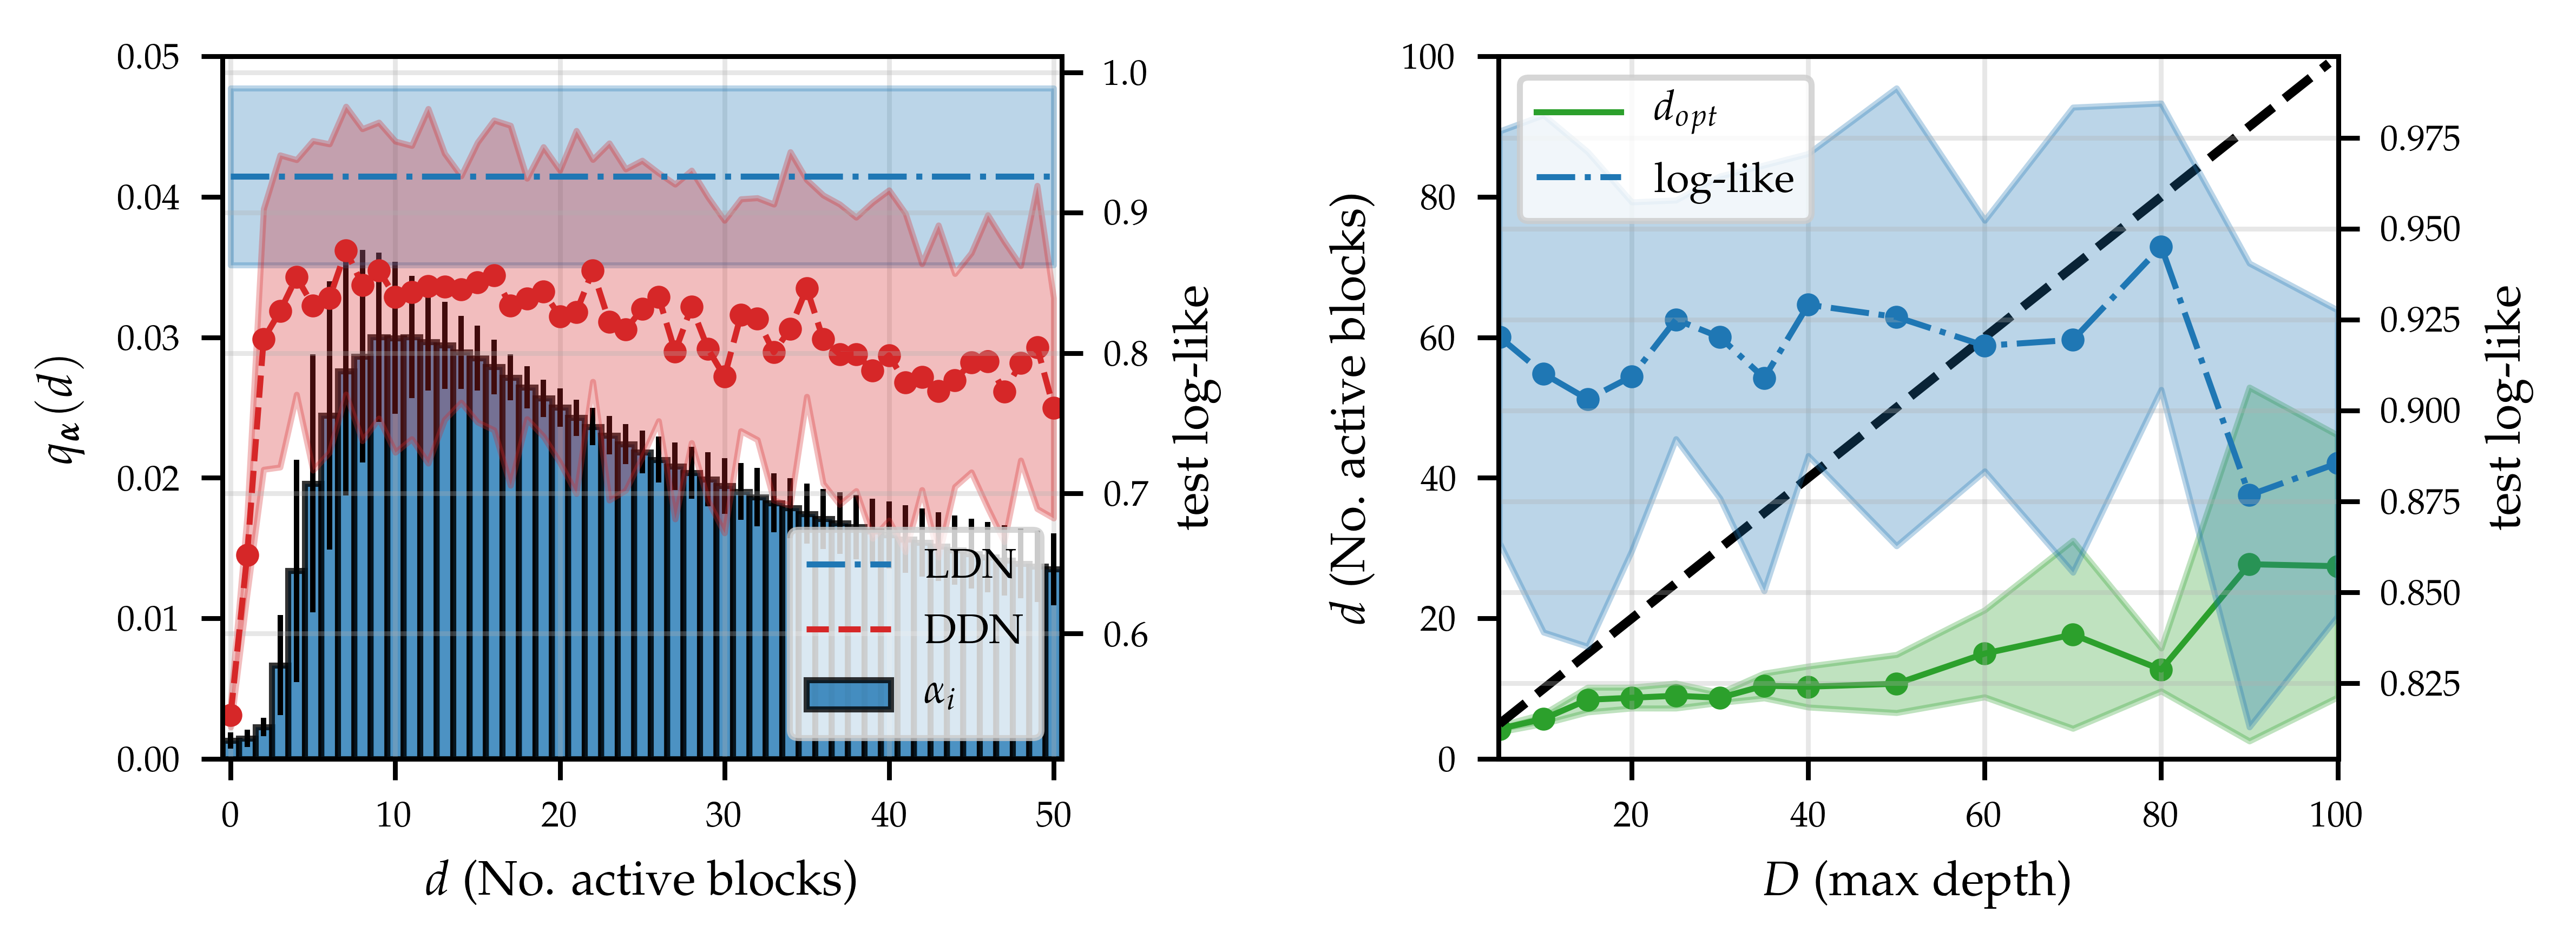

In [66]:

n_layers = 50

# deterministic
perdd_te_ll_means, perdd_te_ll_stds = get_run_mean_std(per_d_depth_test_loglike)
perdd_tr_ll_means, perdd_tr_ll_stds = get_run_mean_std(per_d_depth_train_loglike)

# Proposed full depth
depth_means, depth_stds = get_run_mean_std(per_max_depth_q, last_argmax=True)
te_ll_means, te_ll_stds = get_run_mean_std(per_max_depth_test_loglike)
tr_ll_means, tr_ll_stds = get_run_mean_std(per_max_depth_train_loglike)

# Prune depth
te_ll_means_d, te_ll_stds_d = get_run_mean_std(per_max_depth_test_loglike_d)
tr_ll_means_d, tr_ll_stds_d = get_run_mean_std(per_max_depth_train_loglike_d)


# get results at depth 50 
depth_50_probs = per_max_depth_q[8].mean(axis=0)
depth_50_probs_std = per_max_depth_q[8].std(axis=0)

learnt_depth_ll_mean = te_ll_means_d[8]
learnt_depth_ll_std = te_ll_stds_d[8]

######################################################################################3

markersize = 0.05
lw = 1
s=8
dpi=800 # scale up for results

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=dpi, figsize=(1.1*text_width, 2.3))



bars = ax[0].bar(range(n_layers + 1), depth_50_probs, width=(1/n_layers + 1), yerr=depth_50_probs_std,
        alpha=0.8, label='$\alpha_{i}$', color=c[0], edgecolor='k', error_kw=dict(lw=0.9))

ax[0].set_xlabel('$d$  (No. active blocks)')
ax[0].set_ylabel(r'$q_{\boldsymbol{\alpha}}(d)$')
ax[0].set_ylim([0, 0.05])

ax02 = ax[0].twinx()
our_line, = errorfill(range(n_layers + 1), np.array([learnt_depth_ll_mean]*(n_layers + 1)),
          np.array([learnt_depth_ll_std]*(n_layers + 1)),
          color=c[0], alpha_fill=0.3, ax=ax02, lw=lw, linestyle='-.')

det_depth_line, = errorfill(range(n_layers + 1), perdd_te_ll_means[:n_layers+1], perdd_te_ll_stds[:n_layers+1],
          color=c[3], alpha_fill=0.3, ax=ax02, lw=lw, linestyle='--')

ax02.scatter(range(n_layers + 1), perdd_te_ll_means[:n_layers+1], c=c[3], s=s)

ax02.set_ylabel('test log-like')

ax02.yaxis.grid(alpha=0.3)
ax[0].xaxis.grid(alpha=0.3) 

plt.autoscale(enable=True, axis='x', tight=True)

p_lgd = [ our_line, det_depth_line, bars]
lgd = plt.legend(p_lgd,
['LDN', 'DDN', '$\\alpha_{i}$'],
                prop={'size': fs-1, 'weight': 'normal'}, frameon=True, markerscale=markersize)

######### PLOT 2 ########################


depth_errfill, = errorfill(max_depths, depth_means, depth_stds, color=c[2], alpha_fill=0.3,
                          ax=ax[1], lw=lw, linestyle='-')
ax[1].scatter(max_depths, depth_means, c=c[2], s=s)
ax[1].plot(range(np.min(max_depths), max_depths[-1]), range(np.min(max_depths), max_depths[-1]), '--', c='k')


ax[1].set_ylabel('$d$  (No. active blocks)')
ax[1].set_xlabel('$D$  (max depth)')
ax[1].set_xlim([0, 100])
ax[1].set_ylim([0, 100])



ax12 = ax[1].twinx()
ax12.yaxis.grid(alpha=0.3)
ax[1].xaxis.grid(alpha=0.3) 

our_ll_errrfill, = errorfill(max_depths, te_ll_means_d, te_ll_stds_d, color=c[0], alpha_fill=0.3, ax=ax12, lw=lw,
                           linestyle='-.')
ax12.scatter(max_depths, te_ll_means_d, c=c[0], s=s)

ax12.set_ylabel('test log-like')

p_lgd = [depth_errfill, our_ll_errrfill]
lgd = plt.legend(p_lgd,
['$d_{opt}$', 'log-like'],
                prop={'size': fs-1, 'weight': 'normal'}, frameon=True, markerscale=markersize, loc='upper left')

plt.autoscale(enable=True, axis='x', tight=True)



plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.52)
# plt.savefig(plot_savedir + 'toy_depth_exps.pdf', format='pdf', bbox_inches='tight')


## 2 by 2 plots for appendix : Ndata and dset complexity

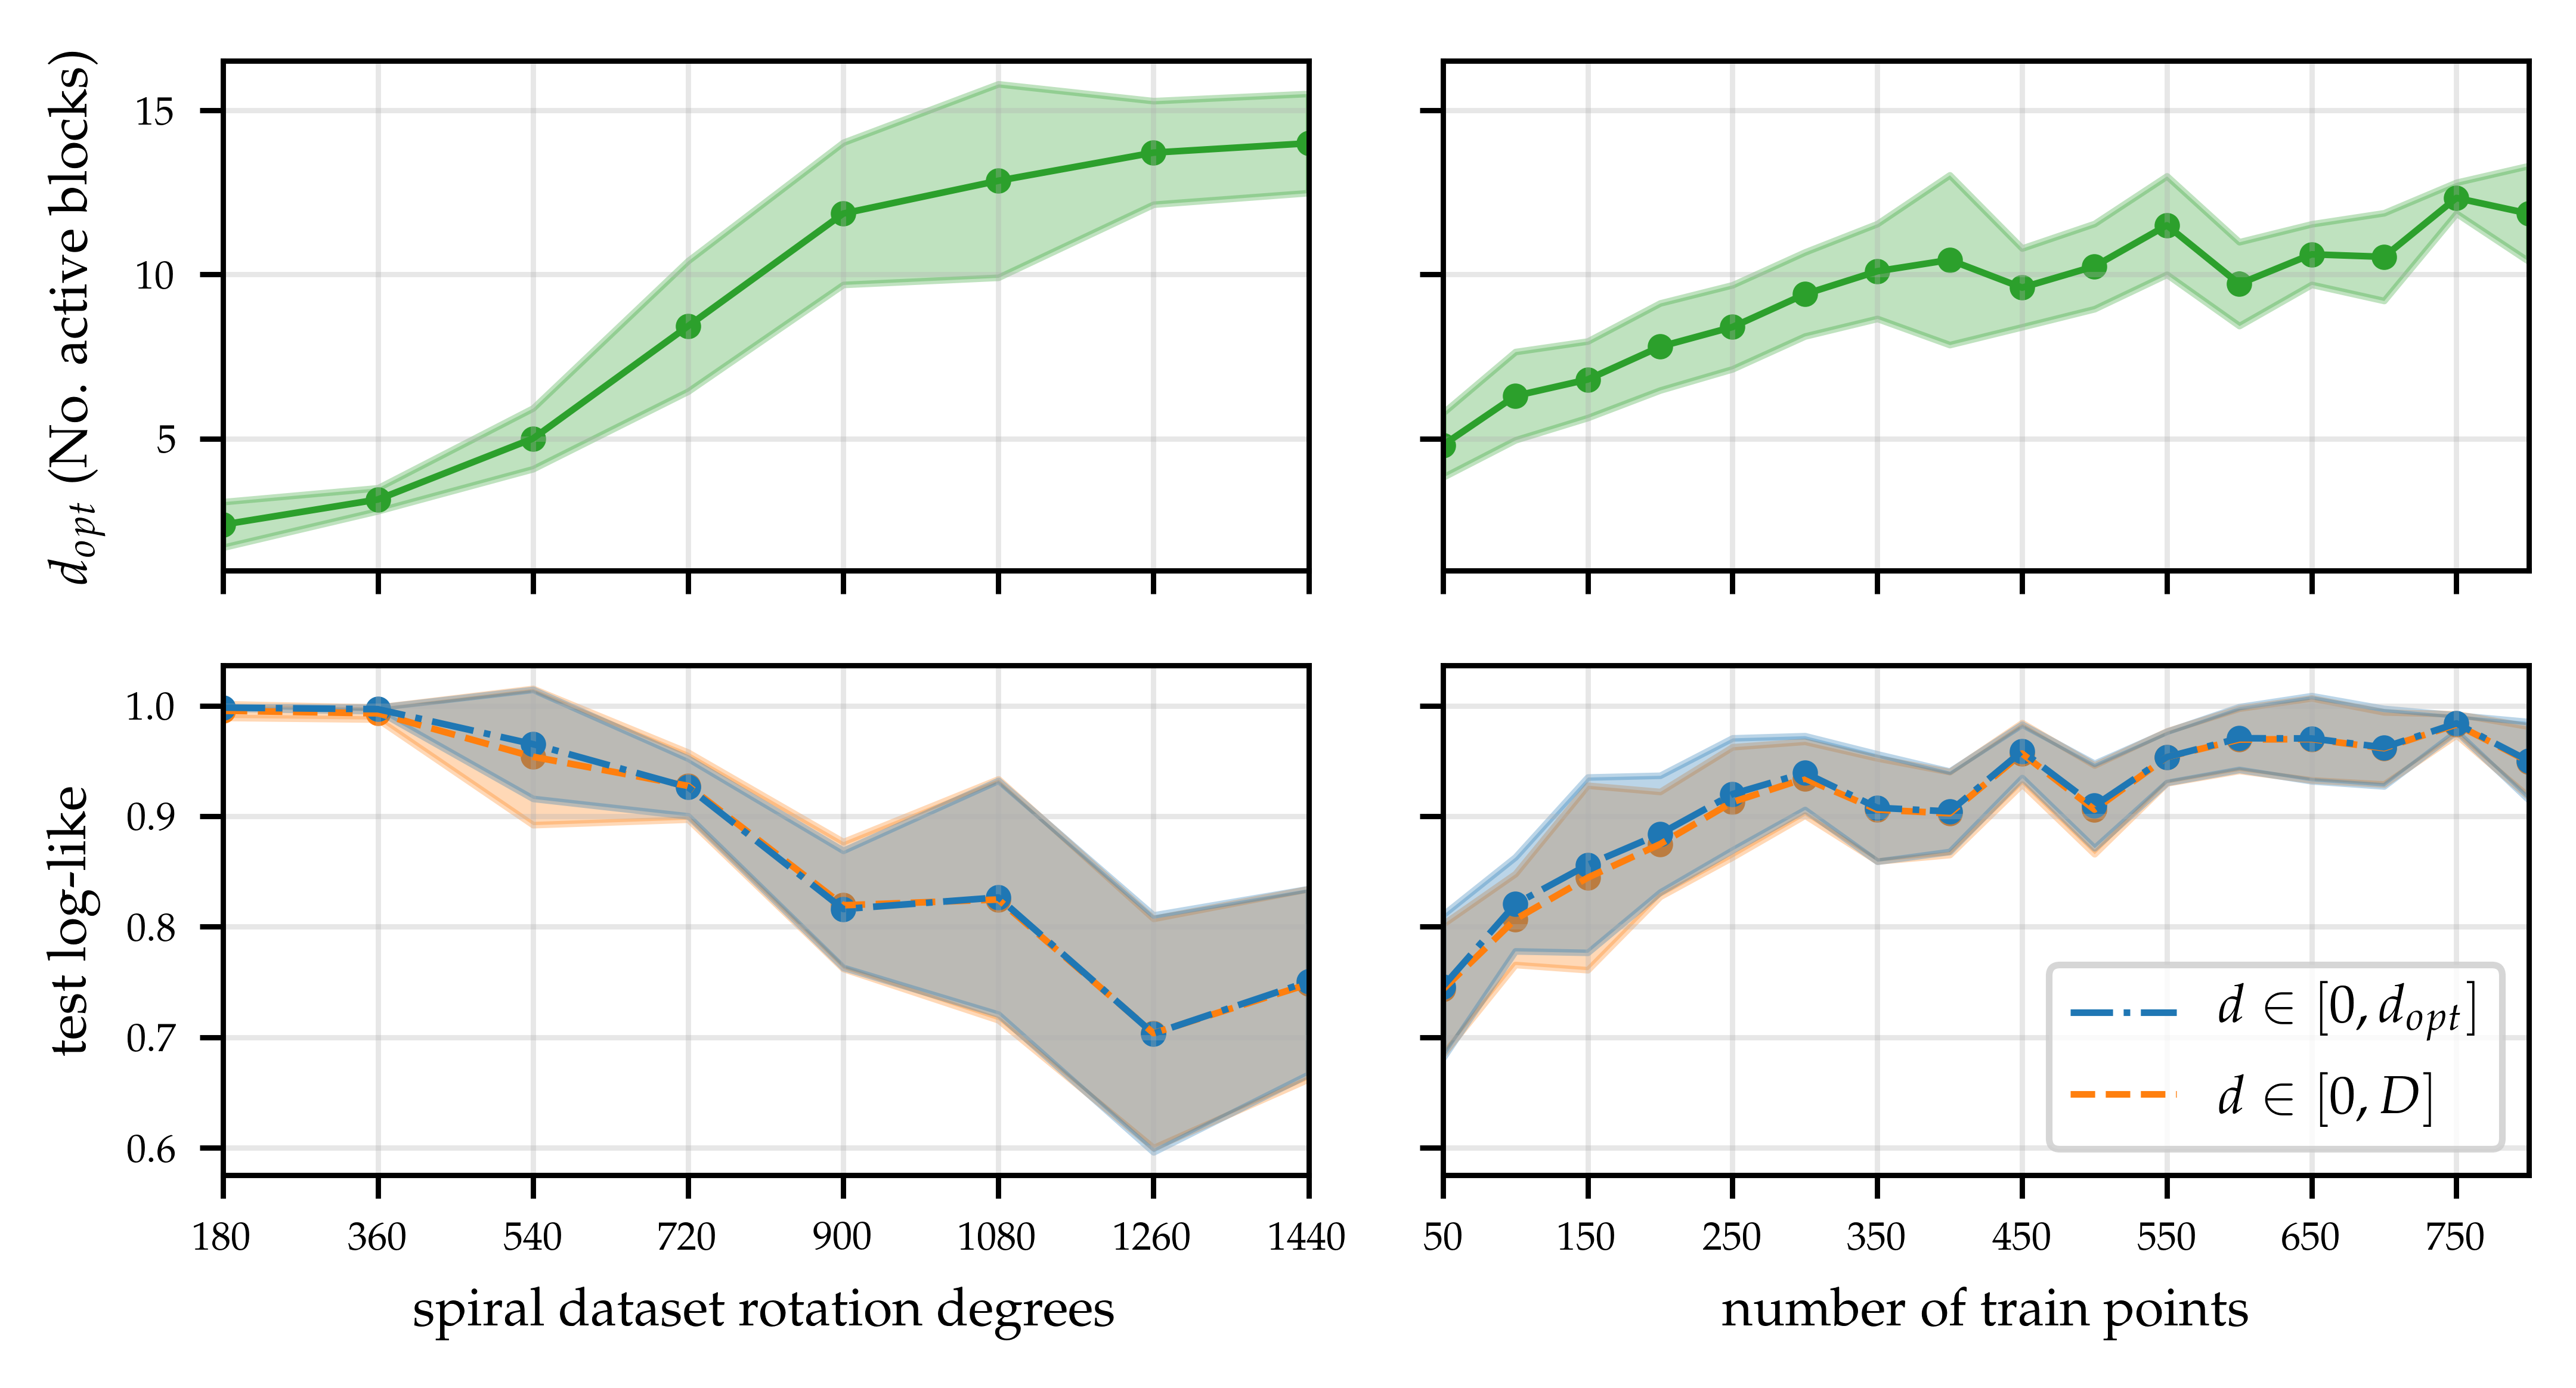

In [70]:


## data Complexity Scan ##

# rotations
depth_means, depth_stds = get_run_mean_std(per_rotation_q, last_argmax=True)
te_ll_means, te_ll_stds = get_run_mean_std(per_rotation_test_loglike)
tr_ll_means, tr_ll_stds = get_run_mean_std(per_rotation_train_loglike)

te_ll_means_d, te_ll_stds_d = get_run_mean_std(per_rotation_test_loglike_d)
tr_ll_means_d, tr_ll_stds_d = get_run_mean_std(per_rotation_train_loglike_d)

#####################################################################################


markersize = 0.05
lw = 1
s=8
dpi=800 # scale up for results



fix, ax = plt.subplots(nrows=2, ncols=2, dpi=dpi, sharex='col', sharey='row',
                       figsize=(1*text_width, text_width*0.55))

## 00

errorfill(rotations, depth_means, depth_stds,
          color=c[2], alpha_fill=0.3, ax=ax[0,0], lw=lw, linestyle='-')
ax[0,0].scatter(rotations, depth_means, c=c[2], s=s)


ax[0,0].yaxis.grid(alpha=0.3)
ax[0,0].xaxis.grid(alpha=0.3) 
ax[0,0].set_xticks(rotations)
ax[0,0].set_xlim([rotations[0], rotations[-1]])

ax[0,0].set_ylabel('$d_{opt}$  (No. active blocks)')

# plt.autoscale(enable=True, axis='x', tight=True)

## 10

errorfill(rotations, te_ll_means, te_ll_stds,
          color=c[1], alpha_fill=0.3, ax=ax[1,0], lw=lw, linestyle='--')
ax[1,0].scatter(rotations, te_ll_means, c=c[1], s=s)

errorfill(rotations, te_ll_means_d, te_ll_stds_d,
          color=c[0], alpha_fill=0.3, ax=ax[1,0], lw=lw, linestyle='-.')
ax[1,0].scatter(rotations, te_ll_means_d, c=c[0], s=s)

ax[1,0].set_xlabel('spiral dataset rotation degrees')
ax[1,0].set_ylabel('test log-like')

ax[1,0].yaxis.grid(alpha=0.3)
ax[1,0].xaxis.grid(alpha=0.3) 
ax[1,0].set_xticks(rotations)
ax[1,0].set_xlim([rotations[0], rotations[-1]])



## Ndata Scan ##

Ndata_e = Ndata * 0.1

depth_means, depth_stds = get_run_mean_std(per_Ndata_q, last_argmax=True)
te_ll_means, te_ll_stds = get_run_mean_std(per_Ndata_test_loglike)
tr_ll_means, tr_ll_stds = get_run_mean_std(per_Ndata_train_loglike)
kl_means, kl_stds = get_run_mean_std(per_Ndata_KL)

te_ll_means_d, te_ll_stds_d = get_run_mean_std(per_Ndata_test_loglike_d)
tr_ll_means_d, tr_ll_stds_d = get_run_mean_std(per_Ndata_train_loglike_d)

## 01

errorfill(Ndata_e, depth_means, depth_stds,
          color=c[2], alpha_fill=0.3, ax=ax[0,1], lw=lw, linestyle='-')
ax[0,1].scatter(Ndata_e, depth_means, c=c[2], s=s)



ax[0,1].yaxis.grid(alpha=0.3)
ax[0,1].xaxis.grid(alpha=0.3) 
ax[0,1].set_xticks(Ndata_e[::2])
ax[0,1].set_xlim([Ndata_e[0], Ndata_e[-1]])

# ax[0,1].set_ylabel('$d$  (No. active blocks)')


## 11

fulld_line, = errorfill(Ndata_e, te_ll_means, te_ll_stds,
          color=c[1], alpha_fill=0.3, ax=ax[1,1], lw=lw, linestyle='--')
ax[1,1].scatter(Ndata_e, te_ll_means, c=c[1], s=s)

our_line, = errorfill(Ndata_e, te_ll_means_d, te_ll_stds_d,
          color=c[0], alpha_fill=0.3, ax=ax[1,1], lw=lw, linestyle='-.')
ax[1,1].scatter(Ndata_e, te_ll_means_d, c=c[0], s=s)


p_lgd = [our_line, fulld_line]
lgd = plt.legend(p_lgd,
['$d \in [0, d_{opt}]$', '$d \in [0, D]$'],
                prop={'size': fs, 'weight': 'normal'}, frameon=True, markerscale=markersize, loc='lower right')

ax[1,1].set_xlabel('number of train points')
# ax[1,1].set_ylabel('test log-like')

ax[1,1].yaxis.grid(alpha=0.3)
ax[1,1].xaxis.grid(alpha=0.3) 
ax[1,1].set_xticks([0]+Ndata_e[::2])
ax[1,1].set_xlim([Ndata_e[0], Ndata_e[-1]])


plt.tight_layout()

# plt.savefig(plot_savedir + 'toy_data_rotation_depths.pdf', format='pdf', bbox_inches='tight')





## Scanning Width vs depth
### Note that this plot is meant for o.45 width

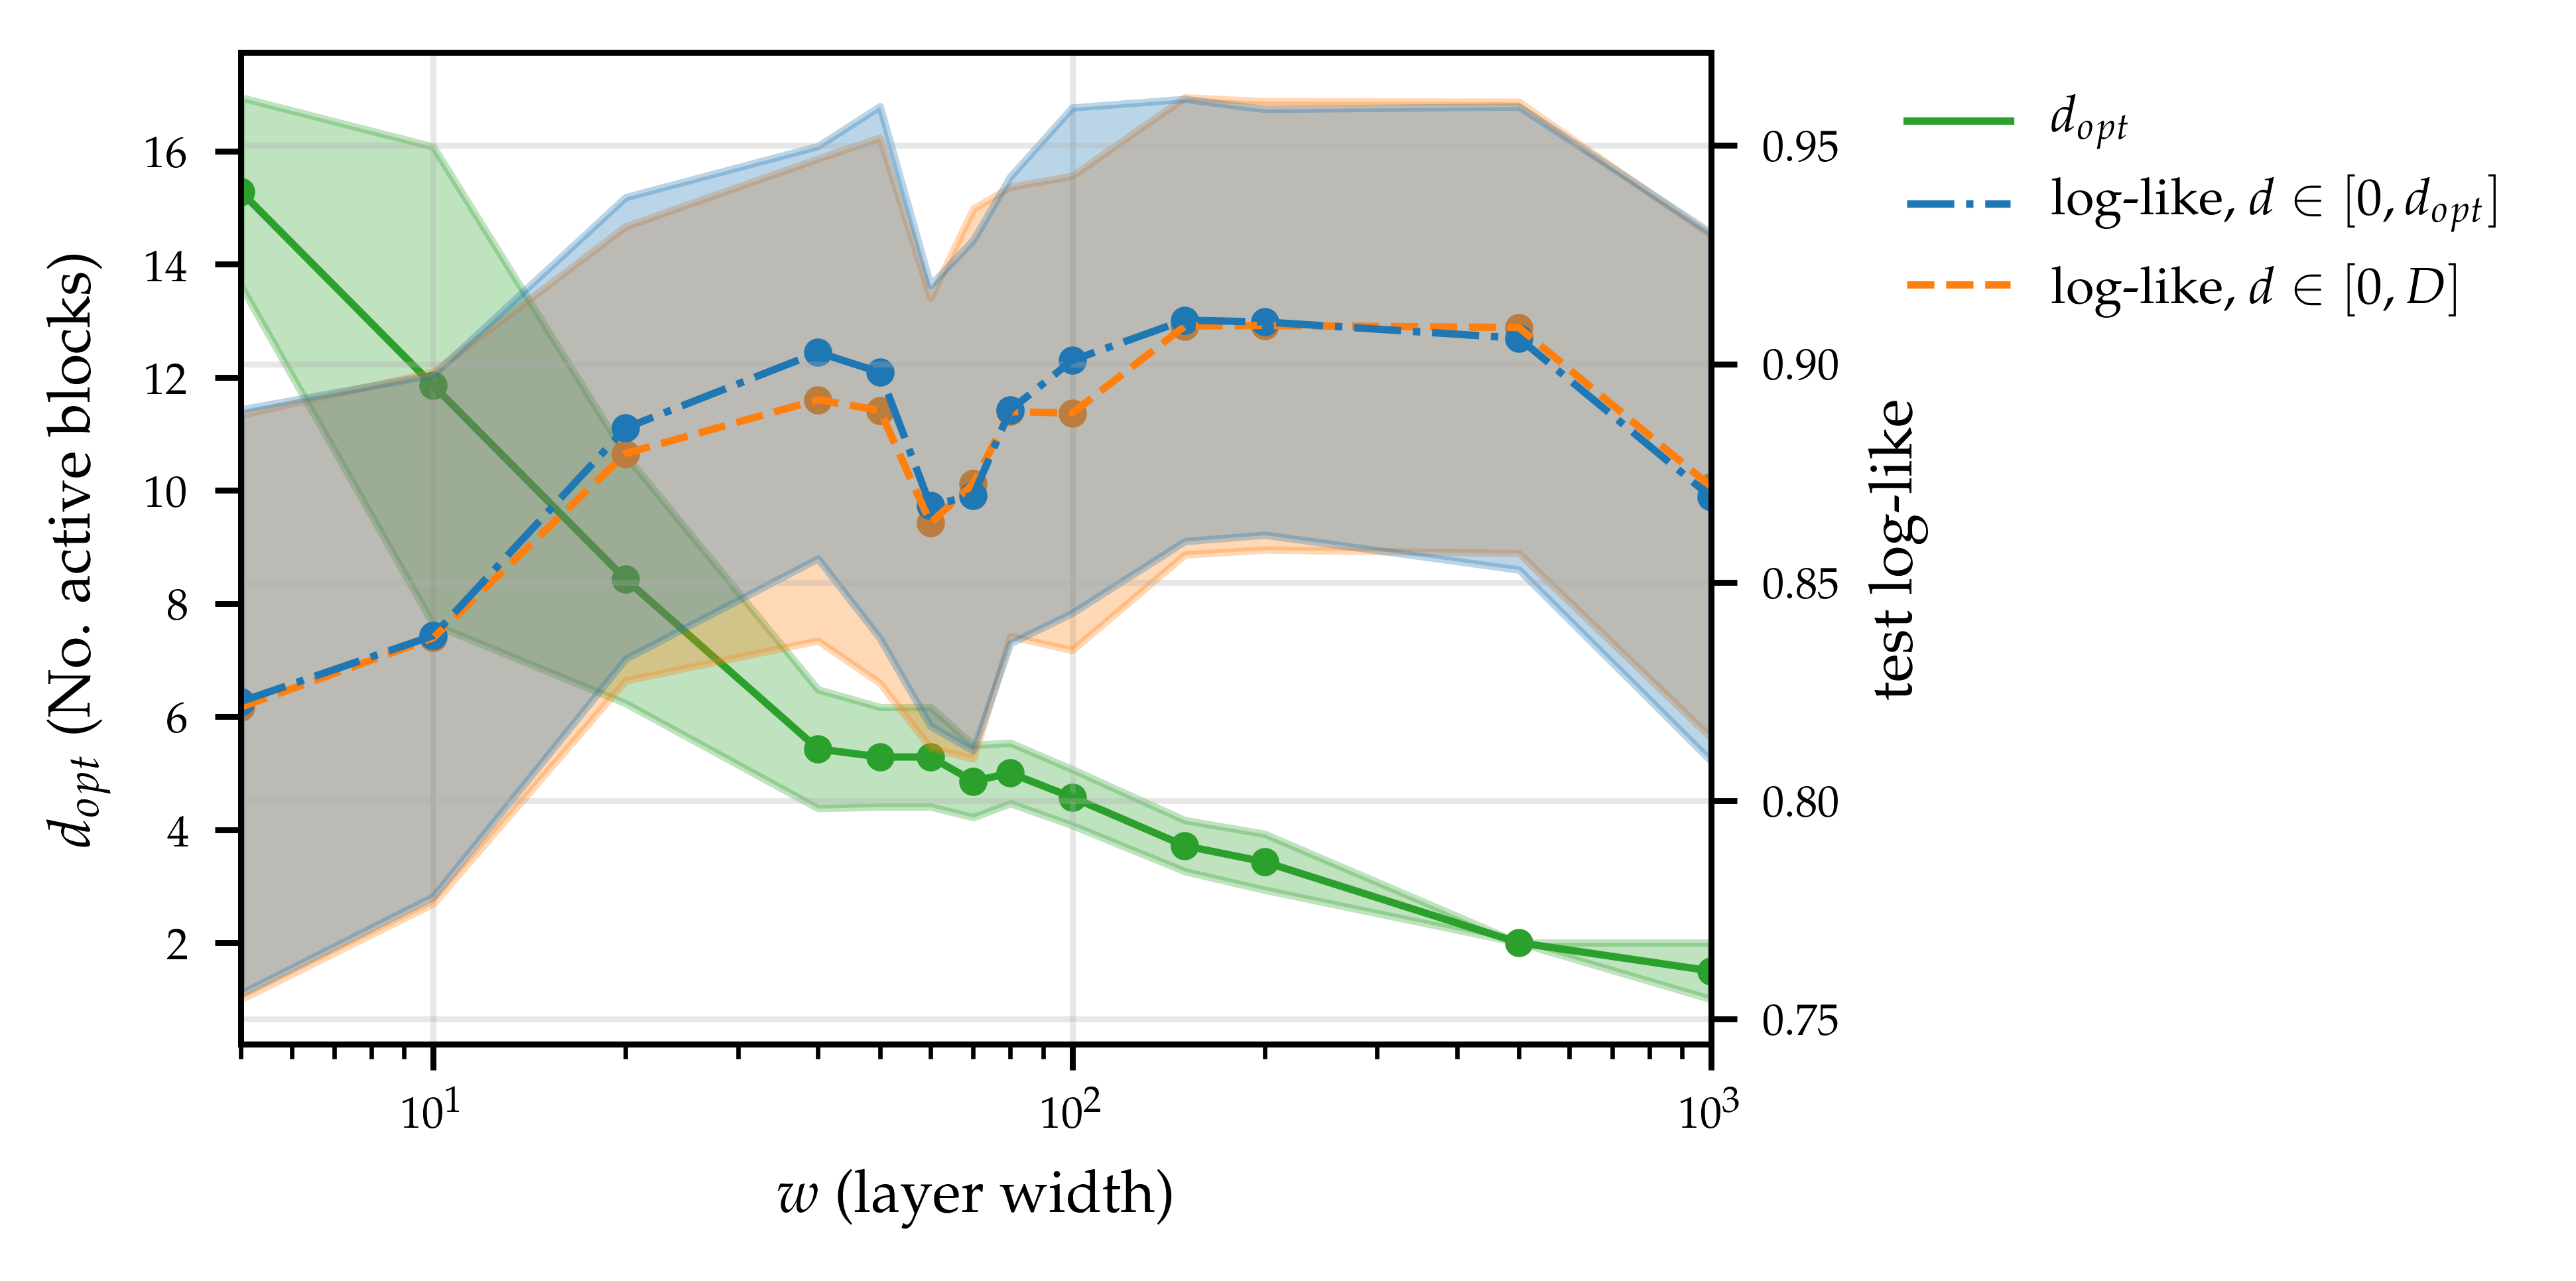

In [192]:

depth_means, depth_stds = get_run_mean_std(per_width_q, last_argmax=True)
te_ll_means, te_ll_stds = get_run_mean_std(per_width_test_loglike)
tr_ll_means, tr_ll_stds = get_run_mean_std(per_width_train_loglike)
kl_means, kl_stds = get_run_mean_std(per_width_KL)

te_ll_means_d, te_ll_stds_d = get_run_mean_std(per_width_test_loglike_d)
tr_ll_means_d, tr_ll_stds_d = get_run_mean_std(per_width_train_loglike_d)

widths_e = widths

########################################

markersize = 0.05
lw = 1
s=8
dpi=800 # scale up for results

plt.figure(dpi=dpi, figsize=(0.65*text_width, text_width*0.45))
ax = plt.gca()


depth_errfill, = errorfill(widths_e, depth_means, depth_stds, color=c[2], alpha_fill=0.3,
                          ax=ax, lw=lw, linestyle='-')
ax.scatter(widths_e, depth_means, c=c[2], s=s)


ax.set_ylabel('$d_{opt}$  (No. active blocks)')
ax.set_xlabel('$w$  (layer width)')

ax.set_xscale('log')

ax2 = ax.twinx()
ax2.yaxis.grid(alpha=0.3)
ax.xaxis.grid(alpha=0.3) 

full_ll_errrfill, = errorfill(widths_e, te_ll_means, te_ll_stds, color=c[1], alpha_fill=0.3, ax=ax2, lw=lw,
                           linestyle='--')
ax2.scatter(widths_e, te_ll_means, c=c[1], s=s)

our_ll_errrfill, = errorfill(widths_e, te_ll_means_d, te_ll_stds_d, color=c[0], alpha_fill=0.3, ax=ax2, lw=lw,
                           linestyle='-.')
ax2.scatter(widths_e, te_ll_means_d, c=c[0], s=s)


# ax12.set_ylabel('test log-like')

p_lgd = [depth_errfill, our_ll_errrfill, full_ll_errrfill]
lgd = plt.legend(p_lgd,
['$d_{opt}$', 'log-like, $d \in [0, d_{opt}]$', 'log-like, $d \in [0, D]$'],
                prop={'size': fs-1, 'weight': 'normal'}, frameon=False,
                 markerscale=markersize, loc='upper right', bbox_to_anchor=(1.57, 1.))

ax.set_xlim([widths_e[0], widths_e[-1]])

ax2.set_ylabel('test log-like')

# plt.savefig(plot_savedir + 'width_depths.pdf', format='pdf', bbox_inches='tight')



## Toy dset callibration vs deterministic and full integration
This is too random to get a good idea of what is hapenning
Make into a 1x3 plot


Net:
MF BNN categorical output
    Total params: 0.02M
Reading ../saves/fc_BNN_spirals_cat/depth_scan/50/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000

Net:
MF BNN categorical output
    Total params: 0.02M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/50/version_4/models/theta_best.dat

  restoring epoch: 61, lr: 0.100000


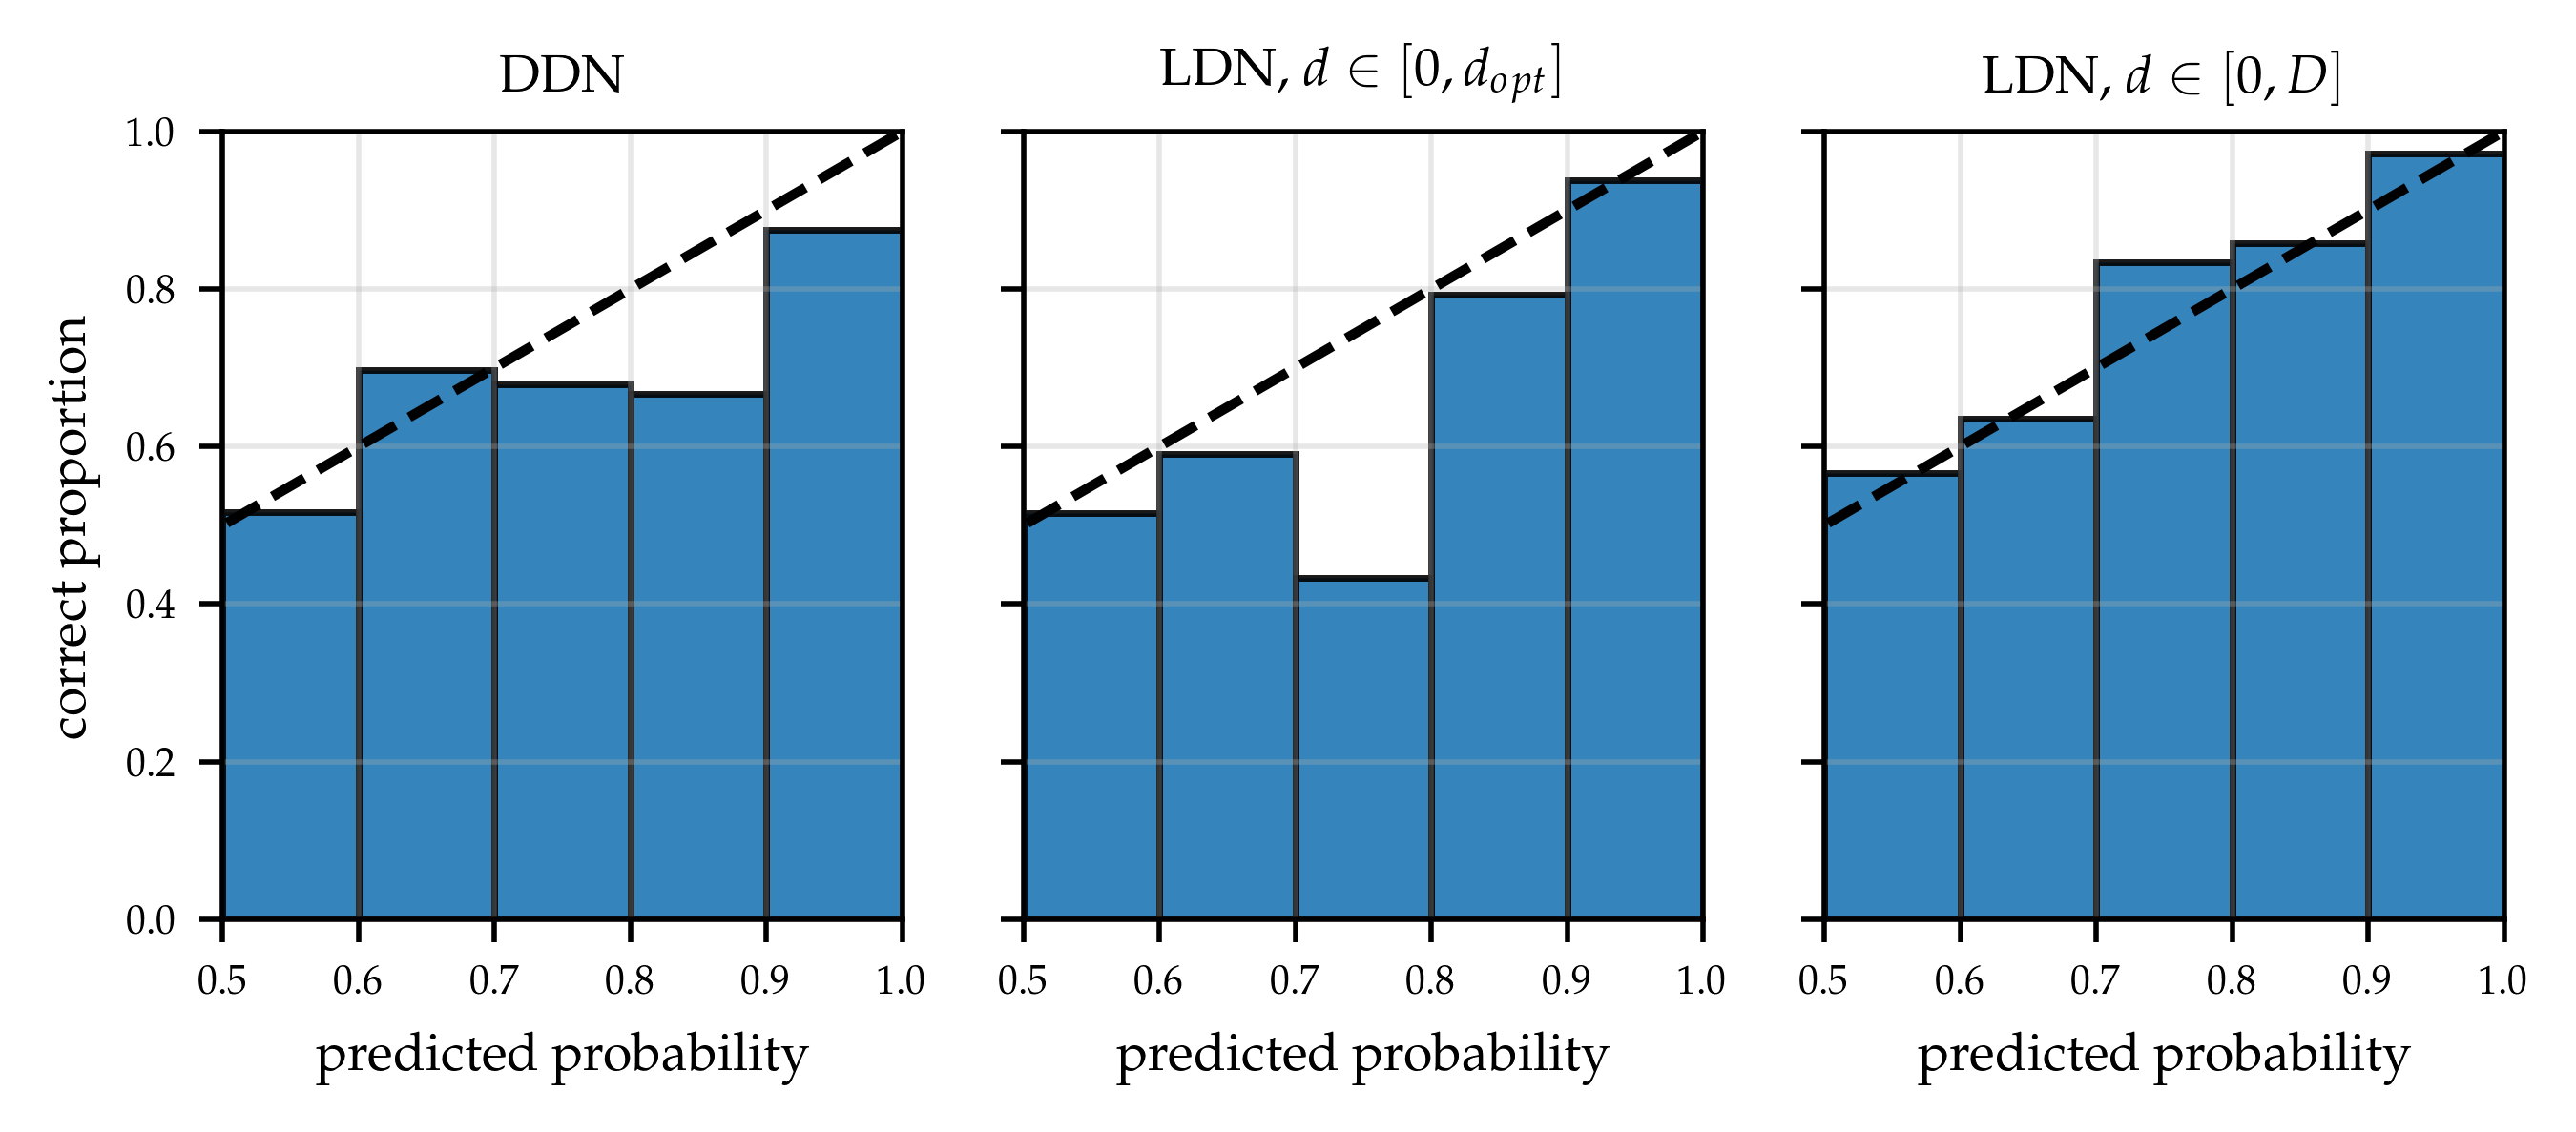

In [413]:
%matplotlib inline
from src.utils import np_get_one_hot

def plot_calibration_curve_probs(probs, y_test, n_bins=10, dpi=200, grid_alph=0.3, yax=True, title=None, ax=None):

    all_preds = probs
    pred_class = np.argmax(all_preds, axis=1)

    expanded_preds = np.reshape(all_preds, -1)
    # These reshapes on the one hot vectors count every possible class as a different prediction
    pred_class_OH_expand = np.reshape(np_get_one_hot(pred_class, probs.shape[1]), -1)
    targets_class_OH_expand = np.reshape(np_get_one_hot(y_test.reshape(-1, 1).astype(int), probs.shape[1]), -1)
    correct_vec = (targets_class_OH_expand * (pred_class_OH_expand == targets_class_OH_expand)).astype(int)

    #############################################

    bin_limits = np.linspace(0, 1, n_bins + 1)

    bin_step = bin_limits[1] - bin_limits[0]
    bin_centers = bin_limits[:-1] + bin_step / 2

    bin_idxs = np.digitize(expanded_preds, bin_limits, right=True) - 1

    bin_counts = np.ones(n_bins)
    bin_corrects = np.zeros(n_bins)
    for nbin in range(n_bins):
        bin_counts[nbin] = np.sum((bin_idxs == nbin).astype(int))
        bin_corrects[nbin] = np.sum(correct_vec[bin_idxs == nbin])

    bin_probs = bin_corrects / bin_counts

    if ax is None:
        plt.figure(dpi=dpi)
        ax = plt.gca()
    bar_ret = ax.bar(bin_centers, bin_probs, 1 / n_bins, edgecolor='k', alpha=0.9)
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), '--', c='k')

    ax.set_xlabel('predicted probability')
    if yax:
        ax.set_ylabel('correct proportion')

    if title is not None:
        ax.set_title(title)
    ax.set_xticks(bin_limits)
    ax.yaxis.grid(alpha=grid_alph)
    ax.xaxis.grid(alpha=grid_alph)
    ax.set_ylim((0, 1))
    if probs.shape[1] == 2:
        ax.set_xlim((0.5, 1))
    else:
        ax.set_xlim((0, 1))

    return bar_ret

# X_train, X_test, y_train, y_test = load_spirals_t(4)

X_train, X_test, y_train, y_test = load_spirals_ndata(10)


########################
## Load prob model
N_version = 0
n_layers = 50

####################

cuda = torch.cuda.is_available()
input_dim = 2
width = 20
output_dim = 2
# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)
# prob_model = fixed_probs(n_layers, probs=[1/(n_layers+1)], distribution_name='cat', cuda=True)
tags = {'direct_trained': True}
N_train = 2000 * 0.1
lr = 1e-1
prior_probs = 0.85 ** (1 + np.arange(n_layers + 1))
prior_probs = prior_probs / prior_probs.sum()
prob_model = variational_categorical(n_layers, prior_probs, temp=0.1, eps=1e-10, cuda=cuda)
model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=width, n_layers=n_layers, prob_model=prob_model)
net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)

net.load('../saves/fc_BNN_spirals_cat/depth_scan/' + str(n_layers) + '/version_%d/models' % N_version 
         + '/theta_best.dat')

chosen_depth = net.model.prob_model.get_q_probs().data.cpu().numpy().argmax()

our_probs = net.partial_predict(X_test, depth=chosen_depth).sum(dim=0).data.cpu().numpy()
full_int_probs = net.sample_predict(X_test).sum(dim=0).data.cpu().numpy()

# Load Det Model #######

probs = np.zeros(n_layers + 1)
probs[-1] = 1

prob_model = fixed_probs(n_layers, probs=probs, distribution_name='cat', cuda=True)
model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=width, n_layers=n_layers, prob_model=prob_model)
net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)
net.load('../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/' + str(n_layers) + '/version_%d/models' % N_version 
         + '/theta_best.dat')

det_probs = net.sample_predict(X_test).sum(dim=0).data.cpu().numpy()

# Gen Plots  ##############
# from src.plots import plot_calibration_curve_probs

dpi=500

fix, ax = plt.subplots(nrows=1, ncols=3, dpi=dpi,
                       figsize=(1*text_width, text_width*0.45), sharey='row')


plot_calibration_curve_probs(det_probs, y_test, n_bins=10, dpi=200, grid_alph=0.3, yax=True, title='DDN', ax=ax[0])
plot_calibration_curve_probs(our_probs, y_test, n_bins=10, dpi=200, grid_alph=0.3, yax=False, title='LDN, $d \in [0, d_{opt}]$', ax=ax[1])
plot_calibration_curve_probs(full_int_probs, y_test, n_bins=10, dpi=200, grid_alph=0.3, yax=False, title='LDN, $d \in [0, D]$', ax=ax[2])

plt.tight_layout()



# plt.savefig(plot_savedir + 'spiral_callibration2.pdf', format='pdf', bbox_inches='tight')


## 2d input space plots
### Because of random seeds not being reliable, will have to some manual mean and std callibration for plotted points

In [714]:
from src.utils import generate_ind_batch

# X_train, X_test, y_train, y_test = load_spirals_t(4, plotnorm=True)
# spiral_datavec = [X_train, X_test, y_train, y_test]
# np.save(save_dir+'/spiral_datavec.npy', spiral_datavec)
X_train, X_test, y_train, y_test = np.load(save_dir+'/spiral_datavec.npy', allow_pickle=True)
extent=2.5
stepdim=800

batch_size = 1024

torch.cuda.empty_cache()

dim_range = np.linspace(-extent, extent, stepdim)
dimx, dimy = np.meshgrid(dim_range, dim_range)
dim_mtx = np.concatenate((np.expand_dims(dimx, 2), np.expand_dims(dimy, 2)), axis=2).reshape((stepdim ** 2, 2))

# VI
input_mtx = torch.from_numpy(dim_mtx).type(torch.FloatTensor)

In [715]:
N_version = 0 
n_layers = 20

cuda = torch.cuda.is_available()
input_dim = 2
width = 20
output_dim = 2
# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)
# prob_model = fixed_probs(n_layers, probs=[1/(n_layers+1)], distribution_name='cat', cuda=True)
tags = {'direct_trained': True}
N_train = 2000 * 0.1
lr = 1e-1
prior_probs = 0.85 ** (1 + np.arange(n_layers + 1))
prior_probs = prior_probs / prior_probs.sum()
prob_model = variational_categorical(n_layers, prior_probs, temp=0.1, eps=1e-10, cuda=cuda)
model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=width, n_layers=n_layers, prob_model=prob_model)
net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)

net.load('../saves/fc_BNN_spirals_cat/depth_scan/' + str(n_layers) + '/version_%d/models' % N_version 
         + '/theta_best.dat')


Net:
MF BNN categorical output
    Total params: 0.01M
Reading ../saves/fc_BNN_spirals_cat/depth_scan/20/version_3/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000


8000

### Function complexity (depth)
Shows how our approach encourages all layers to be used and avoids layers learning identity mappings

In [716]:
depths = [2, 5, 15]

total_stack = []
aux_loader = generate_ind_batch(input_mtx.shape[0], batch_size=batch_size, random=False, roundup=True)
for idxs in aux_loader:
    probs = net.sample_predict(input_mtx[idxs], grad=False).data
    total_stack.append(probs)
prob_mtx = torch.cat(total_stack, dim=1) # append in dim 1 because 0 are probs


prob_mtx = prob_mtx.sum(dim=0)[:,1].cpu().data  # only keep probs for one of the classes
full_prob_mtx = prob_mtx.view(stepdim, stepdim).cpu().numpy()

#####################-------------------------------------------------------########################

chosen_depth = net.model.prob_model.get_q_probs().data.cpu().numpy().argmax()

total_stack = []
aux_loader = generate_ind_batch(input_mtx.shape[0], batch_size=batch_size, random=False, roundup=True)
for idxs in aux_loader:
    probs = net.partial_predict(input_mtx[idxs], depth=chosen_depth).data
    total_stack.append(probs)
prob_mtx = torch.cat(total_stack, dim=1) # append in dim 1 because 0 are probs


prob_mtx = prob_mtx.sum(dim=0)[:,1].cpu().data  # only keep probs for one of the classes
our_prob_mtx = prob_mtx.view(stepdim, stepdim).cpu().numpy()

#####################-------------------------------------------------------########################

bm = torch.ones((n_layers, n_layers)).tril()
bin_mat = np.concatenate([np.zeros((1, n_layers)), bm], axis=0)

total_stack = []
aux_loader = generate_ind_batch(input_mtx.shape[0], batch_size=batch_size, random=False, roundup=True)
for idxs in aux_loader:
    probs = net.vec_predict(input_mtx[idxs], bin_mat).data
    total_stack.append(probs)
prob_mtx = torch.cat(total_stack, dim=1)

depths_prob_mtx = prob_mtx[:, :, 1].view(prob_mtx.shape[0], stepdim, stepdim).cpu().numpy()


## Run with det depth

In [717]:
N_version = 0

probs = np.zeros(n_layers + 1)
probs[-1] = 1

prob_model = fixed_probs(n_layers, probs=probs, distribution_name='cat', cuda=True)
model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=width, n_layers=n_layers, prob_model=prob_model)
net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)
net.load('../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/' + str(n_layers) + '/version_%d/models' % N_version 
         + '/theta_best.dat')

bm = torch.ones((n_layers, n_layers)).tril()
bin_mat = np.concatenate([np.zeros((1, n_layers)), bm], axis=0)

total_stack = []
aux_loader = generate_ind_batch(input_mtx.shape[0], batch_size=batch_size, random=False, roundup=True)
for idxs in aux_loader:
    probs = net.vec_predict(input_mtx[idxs], bin_mat).data
    total_stack.append(probs)
prob_mtx = torch.cat(total_stack, dim=1)

det_depths_prob_mtx = prob_mtx[:, :, 1].view(prob_mtx.shape[0], stepdim, stepdim).cpu().numpy()



Net:
MF BNN categorical output
    Total params: 0.01M
Reading ../saves/fc_BNN_spirals_deterministic_cat/deterministic_depth_scan/20/version_6/models/theta_best.dat

  restoring epoch: 41, lr: 0.100000


#### Plot

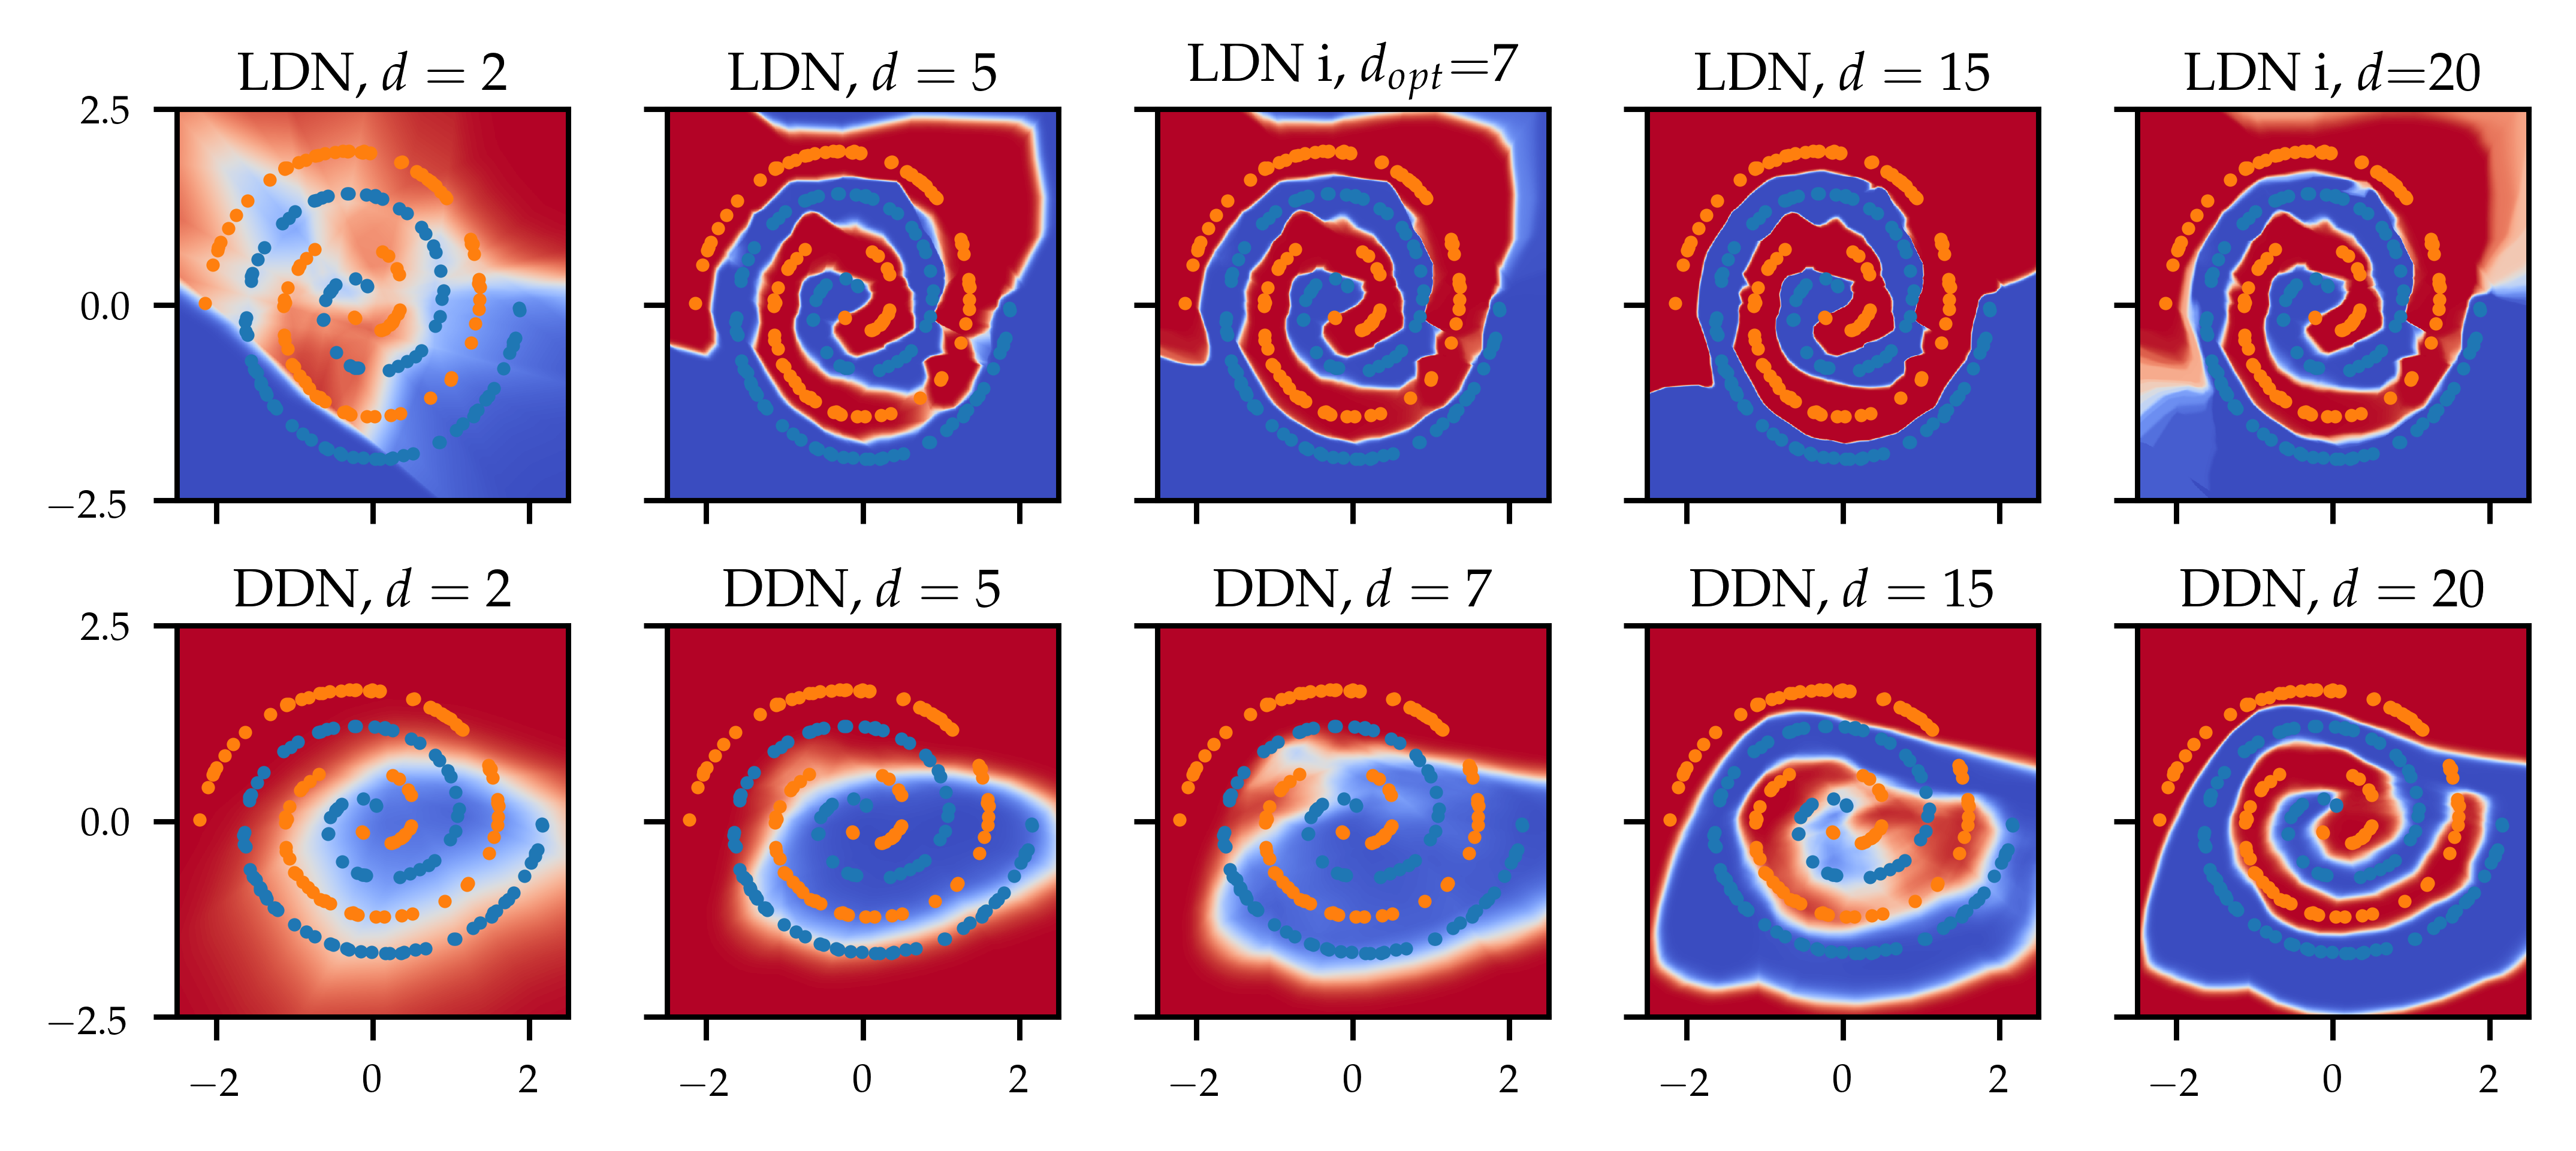

In [718]:
depths = [2, 5, 7, 15]

markersize = 2
dpi=800
tpad = 3

X_train_e = X_train
X_train_d = X_train


fix, ax = plt.subplots(nrows=2, ncols=5, dpi=dpi, sharex='col', sharey='row',
                       figsize=(1*text_width, text_width*0.43))


for ii, dd in enumerate(depths):
    
    if dd != 7:
    
        ax[0, ii].imshow(depths_prob_mtx[dd], extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                         cmap='coolwarm', origin='lower')
        ax[0, ii].set_title('LDN, $d =$ %d' % (dd), pad=tpad)
        for i in range(2):
            idxs = (y_train == i)
            ax[0, ii].plot(X_train_e[idxs, 0], X_train_e[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)

    else:
        ax[0, ii].imshow(our_prob_mtx, extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                         cmap='coolwarm', origin='lower')
        ax[0, ii].set_title('LDN i, $d_{opt}{=}7$', pad=tpad)
        for i in range(2):
            idxs = (y_train == i)
            ax[0, ii].plot(X_train_e[idxs, 0], X_train_e[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)
            

ax[0, ii+1].imshow(full_prob_mtx, extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                   cmap='coolwarm', origin='lower')
ax[0, ii+1].set_title('LDN i, $d{=}20$', pad=tpad)
for i in range(2):
    idxs = (y_train == i)
    ax[0, ii+1].plot(X_train_e[idxs, 0], X_train_e[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)
    
    
    
depths_d = [2, 5, 7, 15, 20]

for ii, dd in enumerate(depths_d):
    ax[1, ii].imshow(det_depths_prob_mtx[dd], extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                     cmap='coolwarm', origin='lower')
    ax[1, ii].set_title('DDN, $d =$ %d' % (dd), pad=tpad)
    for i in range(2):
        idxs = (y_train == i)
        ax[1, ii].plot(X_train_d[idxs, 0], X_train_d[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)
    
ax[1, 0].set_yticks([-2.5,0,2.5])
ax[0, 0].set_yticks([-2.5,0,2.5])
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.32)

# plt.savefig(plot_savedir + 'depth_input_space.pdf', format='pdf', bbox_inches='tight')


### same with colorbar

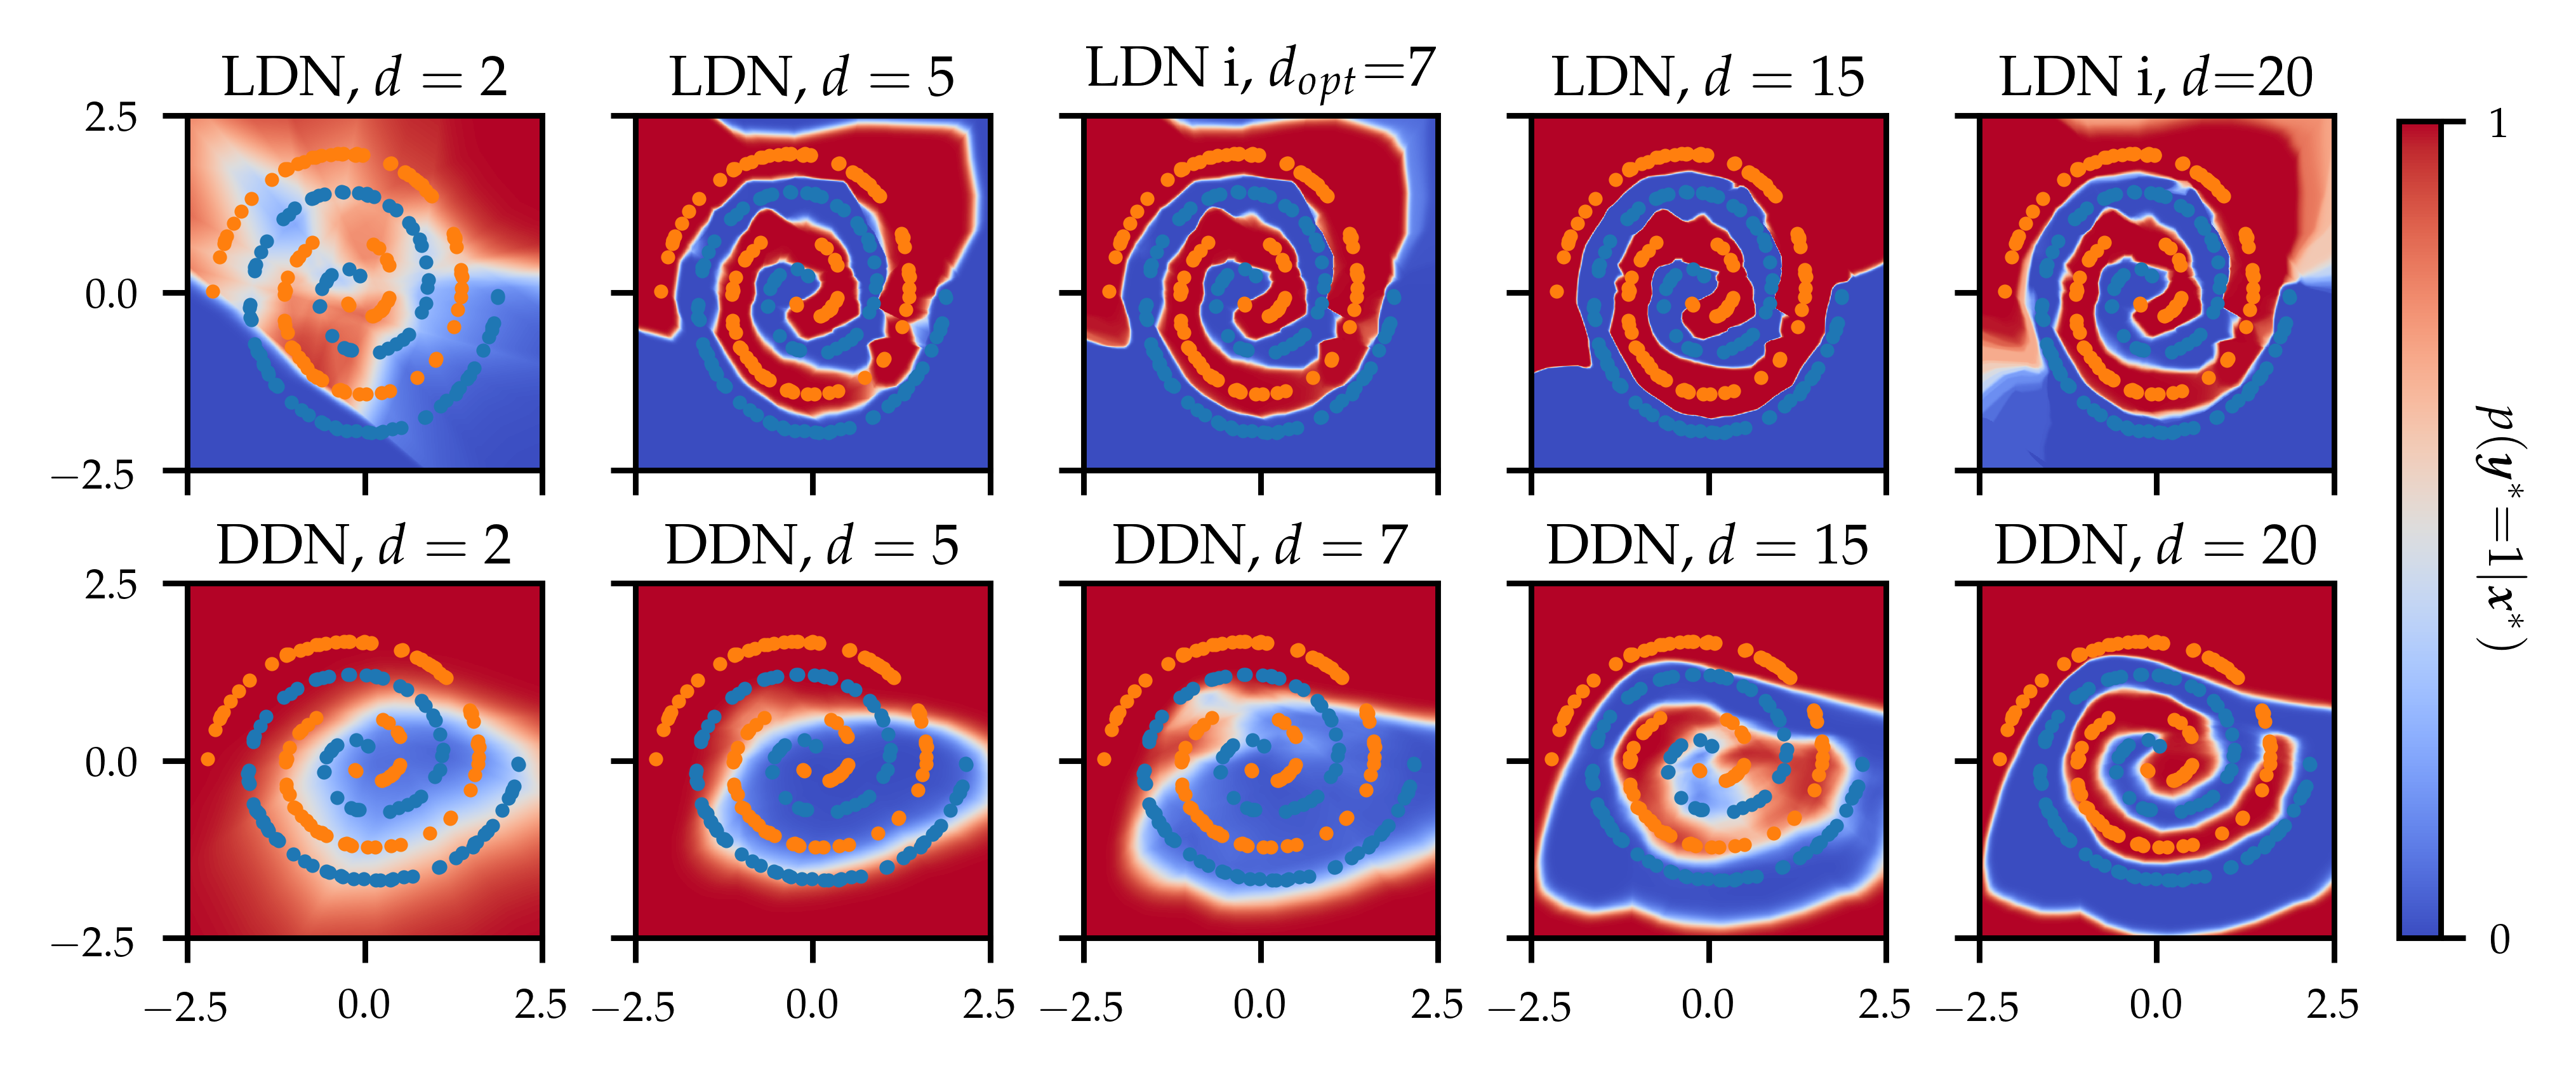

In [719]:
depths = [2, 5, 7, 15]

markersize = 2
dpi=800
tpad = 3


X_train_e = X_train

X_train_d = X_train


fix, ax = plt.subplots(nrows=2, ncols=5, dpi=dpi, sharex='col', sharey='row',
                       figsize=(1*text_width, text_width*0.39))


for ii, dd in enumerate(depths):
    
    if dd != 7:
    
        ax[0, ii].imshow(depths_prob_mtx[dd], extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                         cmap='coolwarm', origin='lower')
        ax[0, ii].set_title('LDN, $d =$ %d' % (dd), pad=tpad)
        for i in range(2):
            idxs = (y_train == i)
            ax[0, ii].plot(X_train_e[idxs, 0], X_train_e[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)

    else:
        ax[0, ii].imshow(our_prob_mtx, extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                         cmap='coolwarm', origin='lower')
        ax[0, ii].set_title('LDN i, $d_{opt}{=}7$', pad=tpad)
        for i in range(2):
            idxs = (y_train == i)
            ax[0, ii].plot(X_train_e[idxs, 0], X_train_e[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)
            

ax[0, ii+1].imshow(full_prob_mtx, extent=(-extent, extent, -extent, extent), cmap='coolwarm', origin='lower')
ax[0, ii+1].set_title('LDN i, $d{=}20$', pad=tpad)
for i in range(2):
    idxs = (y_train == i)
    ax[0, ii+1].plot(X_train_e[idxs, 0], X_train_e[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)
    
    
    
depths_d = [2, 5, 7, 15, 20]

for ii, dd in enumerate(depths_d):
    imm = ax[1, ii].imshow(det_depths_prob_mtx[dd], extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                           cmap='coolwarm', origin='lower')
    ax[1, ii].set_title('DDN, $d =$ %d' % (dd), pad=tpad)
    for i in range(2):
        idxs = (y_train == i)
        ax[1, ii].plot(X_train_d[idxs, 0], X_train_d[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)
    
ax[1, 0].set_yticks([-2.5,0,2.5])
ax[0, 0].set_yticks([-2.5,0,2.5])

###### CBAR time

fix.subplots_adjust(right=0.9)
cbar_ax = fix.add_axes([0.92, 0.126, 0.015, 0.75])
cbar = fix.colorbar(imm, cax=cbar_ax)
cbar.set_ticks([0, 1])
cbar.set_label('$p(\\boldsymbol{y}^{*}{=}1 | \\boldsymbol{x}^{*})$', rotation=270, labelpad=2, fontsize=7)



#####

# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.32)

# plt.savefig(plot_savedir + 'depth_input_space_cbar.pdf', format='pdf', bbox_inches='tight')


### Dataset complexity

In [762]:
from src.utils import generate_ind_batch


extent=2.5
stepdim=800
batch_size = 1024

torch.cuda.empty_cache()

dim_range = np.linspace(-extent, extent, stepdim)
dimx, dimy = np.meshgrid(dim_range, dim_range)
dim_mtx = np.concatenate((np.expand_dims(dimx, 2), np.expand_dims(dimy, 2)), axis=2).reshape((stepdim ** 2, 2))

# VI
input_mtx = torch.from_numpy(dim_mtx).type(torch.FloatTensor)

# Define model ###########

cuda = torch.cuda.is_available()
input_dim = 2
width = 20
n_layers = 20
output_dim = 2

prior_probs = 0.85 ** (1 + np.arange(n_layers + 1))
prior_probs = prior_probs / prior_probs.sum()

# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)

prob_model = variational_categorical(n_layers, prior_probs, temp=0.1, eps=1e-10, cuda=cuda)

# prob_model = fixed_probs(n_layers, probs=[1/(n_layers+1)], distribution_name='cat', cuda=True)

tags = {'direct_trained': True}

model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=width, n_layers=n_layers, prob_model=prob_model)
N_train = 2000 * 0.1
lr = 1e-1
net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)



Net:
MF BNN categorical output
    Total params: 0.01M


In [763]:
N_version = 0

our_probs_mtx_vec = []
full_probs_mtx_vec = []
chose_depth_vec = []

t_vec = [1, 2, 4, 6, 8]

for t in t_vec:
    X_train, X_test, y_train, y_test = load_spirals_t(t)

    net.load('../saves/fc_BNN_spirals_cat/spiral_scan/' + str(t) + '/version_%d/models' % N_version 
             + '/theta_best.dat')
    
    total_stack = []
    aux_loader = generate_ind_batch(input_mtx.shape[0], batch_size=batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        probs = net.sample_predict(input_mtx[idxs], grad=False).data
        total_stack.append(probs)
    prob_mtx = torch.cat(total_stack, dim=1) # append in dim 1 because 0 are probs


    prob_mtx = prob_mtx.sum(dim=0)[:,1].cpu().data  # only keep probs for one of the classes
    full_prob_mtx = prob_mtx.view(stepdim, stepdim).cpu().numpy()
    full_probs_mtx_vec.append(full_prob_mtx)

    #####################-------------------------------------------------------########################

    chosen_depth = net.model.prob_model.get_q_probs().data.cpu().numpy().argmax()
    print(chosen_depth)
    chose_depth_vec.append(chosen_depth)
    total_stack = []
    aux_loader = generate_ind_batch(input_mtx.shape[0], batch_size=batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        probs = net.partial_predict(input_mtx[idxs], depth=chosen_depth).data
        total_stack.append(probs)
    prob_mtx = torch.cat(total_stack, dim=1) # append in dim 1 because 0 are probs


    prob_mtx = prob_mtx.sum(dim=0)[:,1].cpu().data  # only keep probs for one of the classes
    our_prob_mtx = prob_mtx.view(stepdim, stepdim).cpu().numpy()
    our_probs_mtx_vec.append(our_prob_mtx)
    

Reading ../saves/fc_BNN_spirals_cat/spiral_scan/1/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
2
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/2/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
3
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/4/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
6
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/6/version_4/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
10
Reading ../saves/fc_BNN_spirals_cat/spiral_scan/8/version_4/models/theta_best.dat

  restoring epoch: 1719, lr: 0.100000
16


#### Plot

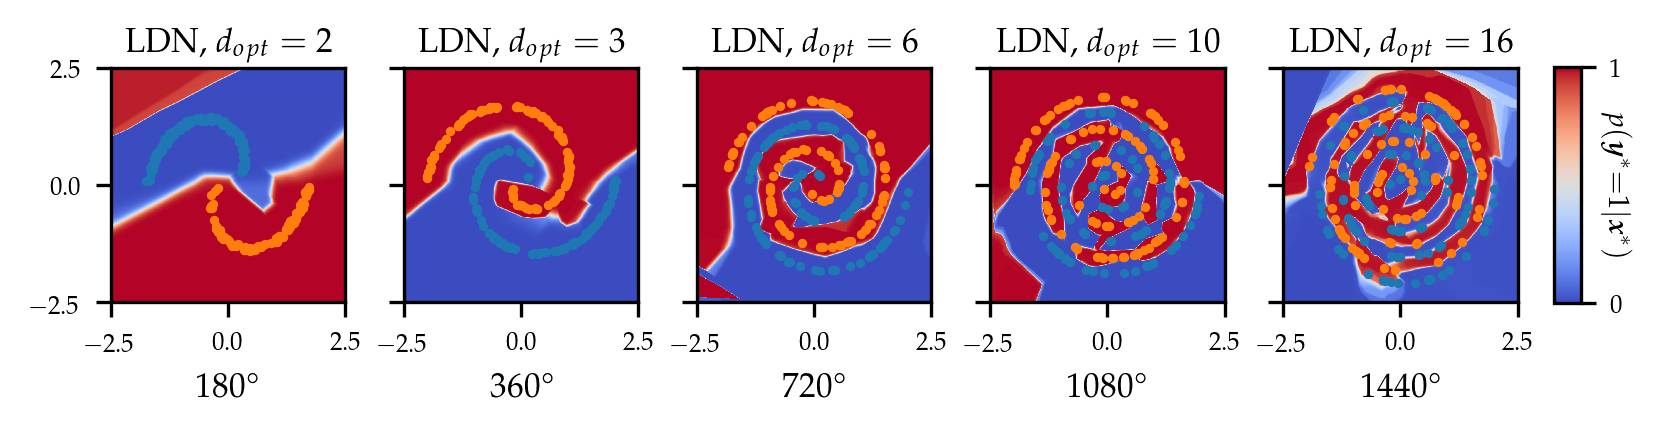

In [765]:

markersize = 2.5
dpi=300
tpad = 3


fix, ax = plt.subplots(nrows=1, ncols=5, dpi=dpi, sharex='col', sharey='row',
                       figsize=(1.1*text_width, text_width*0.3))

for dd in range(len(t_vec)):
    t = t_vec[dd]
    X_train, X_test, y_train, y_test = load_spirals_t(t, plotnorm=True)
    
    X_train = X_train

    ax[dd].imshow(our_probs_mtx_vec[dd], extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                   cmap='coolwarm', origin='lower')
    ax[dd].set_title('LDN, $d_{opt} =$ %d' % (chose_depth_vec[dd]), pad=tpad)
    ax[dd].set_xlabel('%d°'% (180*t_vec[dd]))
    
    for i in range(2):
        idxs = (y_train == i)
        ax[dd].plot(X_train[idxs, 0], X_train[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)


###### CBAR time

fix.subplots_adjust(right=0.9)
cbar_ax = fix.add_axes([0.92, 0.265, 0.015, 0.475])
cbar = fix.colorbar(imm, cax=cbar_ax)
cbar.set_ticks([0, 1])
cbar.set_label('$p(\\boldsymbol{y}^{*}{=}1 | \\boldsymbol{x}^{*})$', rotation=270, labelpad=2, fontsize=7)


ax[0].set_yticks([-2.5,0,2.5])

for i in range(len(ax)):
    ax[i].set_xticks([-2.5,0,2.5])

#####

# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0)

# plt.savefig(plot_savedir + 'input_data_complexity.pdf', format='pdf', bbox_inches='tight')

#####################



        
        

### Ndata

In [766]:
from src.utils import generate_ind_batch

# X_train, X_test, y_train, y_test = load_spirals_t(4)
extent=2.5
stepdim=800
batch_size = 1024

torch.cuda.empty_cache()

dim_range = np.linspace(-extent, extent, stepdim)
dimx, dimy = np.meshgrid(dim_range, dim_range)
dim_mtx = np.concatenate((np.expand_dims(dimx, 2), np.expand_dims(dimy, 2)), axis=2).reshape((stepdim ** 2, 2))

# VI
input_mtx = torch.from_numpy(dim_mtx).type(torch.FloatTensor)

# Define model ###########

cuda = torch.cuda.is_available()
input_dim = 2
width = 20
n_layers = 20
output_dim = 2

prior_probs = 0.85 ** (1 + np.arange(n_layers + 1))
prior_probs = prior_probs / prior_probs.sum()

# prior_probs = np.ones(n_layers + 1)/(n_layers + 1)

prob_model = variational_categorical(n_layers, prior_probs, temp=0.1, eps=1e-10, cuda=cuda)

# prob_model = fixed_probs(n_layers, probs=[1/(n_layers+1)], distribution_name='cat', cuda=True)

tags = {'direct_trained': True}

model = arq_uncert_fc_resnet(input_dim=input_dim, output_dim=output_dim,
                             width=width, n_layers=n_layers, prob_model=prob_model)
N_train = 2000 * 0.1
lr = 1e-1
net = MF_BNN_cat(model, N_train, lr=lr, cuda=cuda, schedule=None)



Net:
MF BNN categorical output
    Total params: 0.01M


In [92]:
from src.utils import generate_ind_batch
N_version = 0

Ndata_vec = [1, 4, 8, 12, 16]

our_probs_mtx_vec = []
full_probs_mtx_vec = []
chose_depth_vec = []

for t in Ndata_vec:
    
    
    net.load('../saves/fc_BNN_spirals_cat/Ndata_scan_savedat/' + str(50*t) + '/version_%d/models' % N_version 
             + '/theta_best.dat')
    
    total_stack = []
    aux_loader = generate_ind_batch(input_mtx.shape[0], batch_size=batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        probs = net.sample_predict(input_mtx[idxs], grad=False).data
        total_stack.append(probs)
    prob_mtx = torch.cat(total_stack, dim=1) # append in dim 1 because 0 are probs


    prob_mtx = prob_mtx.sum(dim=0)[:,1].cpu().data  # only keep probs for one of the classes
    full_prob_mtx = prob_mtx.view(stepdim, stepdim).cpu().numpy()
    full_probs_mtx_vec.append(full_prob_mtx)

    #####################-------------------------------------------------------########################

    chosen_depth = net.model.prob_model.get_q_probs().data.cpu().numpy().argmax()
    chose_depth_vec.append(chosen_depth)

    total_stack = []
    aux_loader = generate_ind_batch(input_mtx.shape[0], batch_size=batch_size, random=False, roundup=True)
    for idxs in aux_loader:
        probs = net.partial_predict(input_mtx[idxs], depth=chosen_depth).data
        total_stack.append(probs)
    prob_mtx = torch.cat(total_stack, dim=1) # append in dim 1 because 0 are probs
    
    prob_mtx = prob_mtx.sum(dim=0)[:,1].cpu().data  # only keep probs for one of the classes
    our_prob_mtx = prob_mtx.view(stepdim, stepdim).cpu().numpy()
    our_probs_mtx_vec.append(our_prob_mtx)

Reading ../saves/fc_BNN_spirals_cat/Ndata_scan_savedat/50/version_0/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan_savedat/200/version_0/models/theta_best.dat

  restoring epoch: 8000, lr: 0.100000
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan_savedat/400/version_0/models/theta_best.dat

  restoring epoch: 7999, lr: 0.100000
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan_savedat/600/version_0/models/theta_best.dat

  restoring epoch: 5479, lr: 0.100000
Reading ../saves/fc_BNN_spirals_cat/Ndata_scan_savedat/800/version_0/models/theta_best.dat

  restoring epoch: 2030, lr: 0.100000


#### Plot

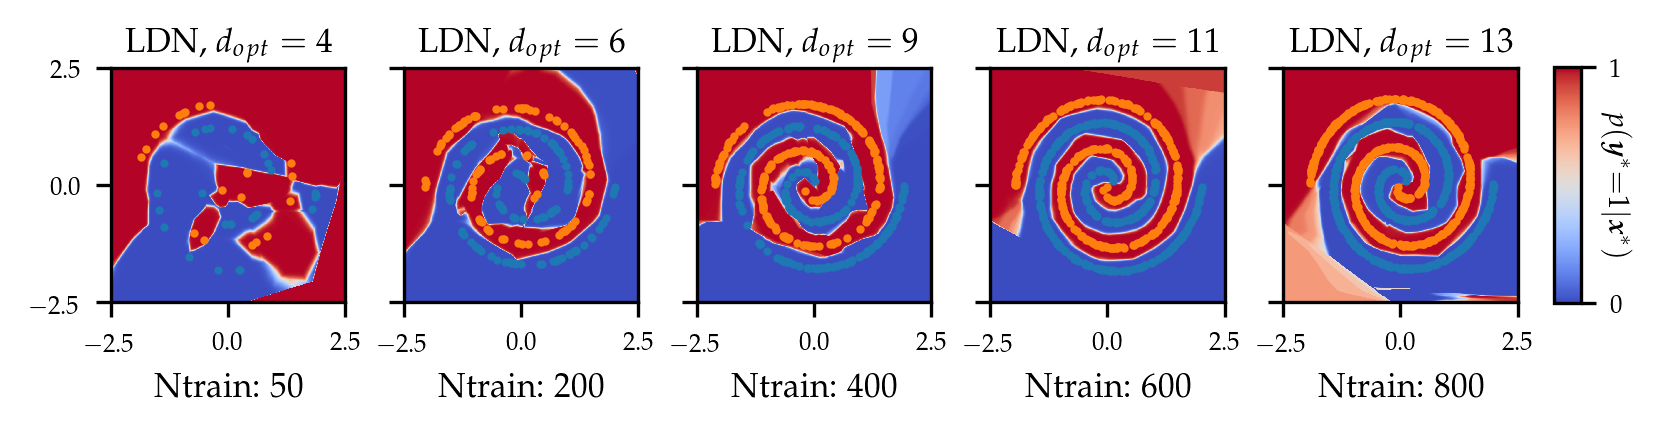

In [95]:

    
markersize = 2
dpi=300
tpad = 3


fix, ax = plt.subplots(nrows=1, ncols=5, dpi=dpi, sharex='col', sharey='row',
                       figsize=(1.1*text_width, text_width*0.3))


for dd in range(len(Ndata_vec)):
    t = Ndata_vec[dd]
    X_train, X_test, y_train, y_test = np.load('../saves/fc_BNN_spirals_cat/Ndata_scan_savedat/' + str(50*t) + '/version_%d/mediadata.npy' % N_version , allow_pickle=True)

    imm=ax[dd].imshow(our_probs_mtx_vec[dd], extent=(-extent, extent, -extent, extent), vmin=0, vmax=1,
                   cmap='coolwarm', origin='lower')
    ax[dd].set_title('LDN, $d_{opt} =$ %d' % (chose_depth_vec[dd]), pad=tpad)
    ax[dd].set_xlabel('Ntrain: %d '% X_train.shape[0])#(50*t_vec[dd]))
    
    for i in range(2):
        idxs = (y_train == i)
        ax[dd].plot(X_train[idxs, 0], X_train[idxs, 1], '.', c=c[i], alpha=1, markersize=markersize)


###### CBAR time

fix.subplots_adjust(right=0.9)
cbar_ax = fix.add_axes([0.92, 0.265, 0.015, 0.475])
cbar = fix.colorbar(imm, cax=cbar_ax)
cbar.set_ticks([0, 1])
cbar.set_label('$p(\\boldsymbol{y}^{*}{=}1 | \\boldsymbol{x}^{*})$', rotation=270, labelpad=2, fontsize=7)


ax[0].set_yticks([-2.5,0,2.5])
for i in range(len(ax)):
    ax[i].set_xticks([-2.5,0,2.5])


#####

# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0)

plt.savefig(plot_savedir + 'input_Ndata.pdf', format='pdf', bbox_inches='tight')

##